# Main

## Import UHI_Functions.py

In [1]:
# Version 2 uses different parameters for both GA and ACO:
# Differerences in GA:
#                      ---Version 1--- ---Version 2---
#  Population Size:        30               300
#  Max iters:              100              150
# Differences in ACO:
#  Num ants:                10               30
# evaporation rate:         0.05              0.2    

In [2]:
from UHI_Function import *
import time

# Load Initial heatmap

### Load map

In [3]:
# Loading the map
type_matrix, temp_matrix, type_pivot, type_to_num, num_to_type = load_map('sample_grid.csv')
H, W = type_matrix.shape

# Derive mininmal and maximal Temperature for scales in plots
vmin,vmax = np.min(temp_matrix),np.max(temp_matrix)

# Derive heat islands
heatislands = detect_heat_islands(temp_matrix)[1]

avg,avg_hotspot = calculate_objective_stats(temp_matrix,temp_matrix)

print(f'Average overall temperature is: {round(avg, 2)}')
print(f'Average hotspot temperature is: {round(avg_hotspot, 2)}')

Average overall temperature is: 29.85
Average hotspot temperature is: 32.96


### Plot initial HeatMap

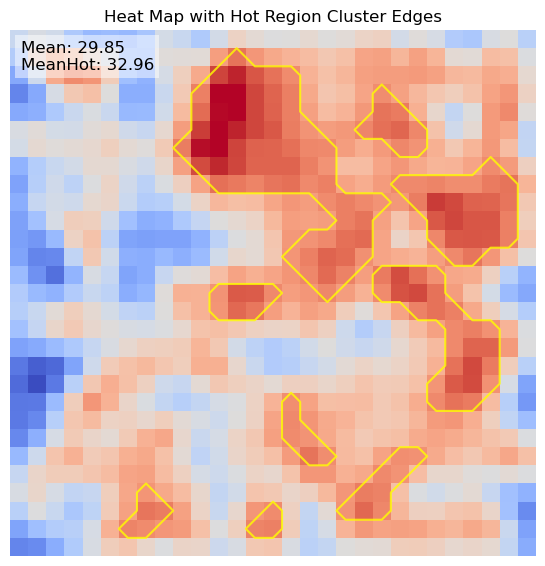

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Heat Map with Hot Region Cluster Edges'}>)

In [4]:
generate_heat_island_map(temp_matrix, temp_matrix, threshold=32, show=True)

### Function random insertion

# Random simulation

In [5]:
def random_insertion(type_matrix, budget_max, type_to_num, tree_species, cost_factor=1.5):
    H, W = type_matrix.shape
    placed_elements = []
    total_cost = 0
    min_tree_cost = min(tree_species[t]['base_price'] for t in tree_species)
    used_cells = set()
    max_iterations = H * W * 10
    iterations = 0

    while total_cost + min_tree_cost <= budget_max and iterations < max_iterations:
        iterations += 1
        row = random.randint(0, H - 1)
        col = random.randint(0, W - 1)

        if type_matrix[row, col] == type_to_num['building'] or (row, col) in used_cells:
            continue

        species = random.choice(list(tree_species.keys()))
        cell_factor = cost_factor if type_matrix[row, col] == type_to_num['road'] else 1.0
        cost = tree_species[species]['base_price'] * cell_factor

        if total_cost + cost > budget_max:
            continue

        placed_elements.append((row, col, species))
        used_cells.add((row, col))
        total_cost += cost

    return placed_elements

In [6]:
random_solution = random_insertion(type_matrix, budget_max, type_to_num, tree_species)

### Plot result random insertion

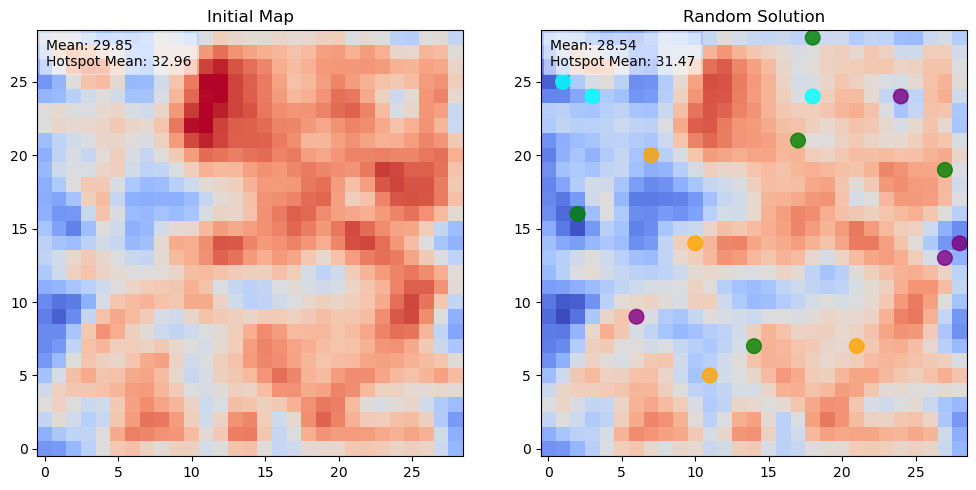

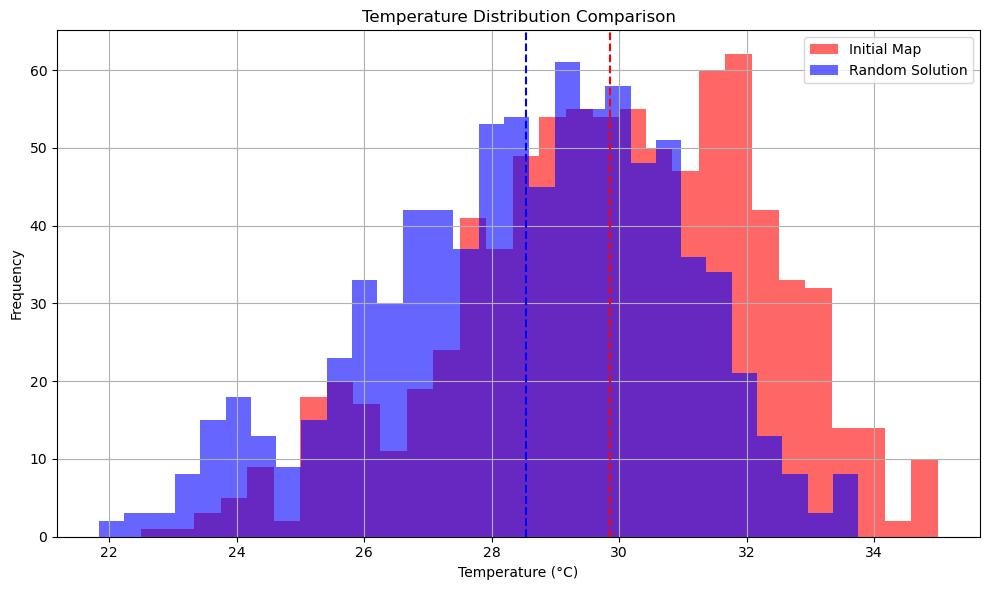

In [7]:
compare_solution_heatmaps([], random_solution, temp_matrix, tree_species,
                          title1="Initial Map", title2="Random Solution")


# Algorithm Preparation

## GA algorithm 

In [8]:
# ===========================
# 5. Optimization - Genetic Algorithm
# ===========================
def run_ga(type_matrix, temp_matrix, budget_max, type_to_num, tree_species,
           pop_size=300, max_iter=150, mutation_prob=0.1):
  
    # --- GA Parameters ---
    dim = 4 * 50  # example: 50 max placements (row, col, species, active_flag)
    varbound = []
    H, W = type_matrix.shape

    for _ in range(50):
        varbound.extend([
            (0, H - 1),        # row
            (0, W - 1),        # col
            (0, len(tree_species) - 1),  # species
            (0, 1)             # active flag
        ])
    varbound = np.array(varbound)

    # --- Objective Function Wrapper ---
    def ga_objective(X):
        solution = []
        for i in range(0, len(X), 4):
            if int(X[i + 3]) == 1:  # active
                row = int(X[i])
                col = int(X[i + 1])
                species = int(X[i + 2])
                solution.append((row, col, species))
        return objective_function(solution, type_matrix, temp_matrix, tree_species,
                                  type_to_num, budget_max)

    # --- Run GA ---
    model = ga(
        function=ga_objective,
        dimension=dim,
        variable_type='int',
        variable_boundaries=varbound,
        algorithm_parameters={
            'max_num_iteration': max_iter,
            'population_size': pop_size,
            'mutation_probability': mutation_prob,
            'elit_ratio': 0.1,
            'crossover_probability': 0.7,
            'parents_portion': 0.3,
            'crossover_type': 'uniform',
            'max_iteration_without_improv': 25
        }
    )

    model.run()
    return model


## ACO algorithm 

In [9]:
# ===========================
# 7. ACO - Ant Colony Optimization
# ===========================
def update_pos_pheromone(best_solution, pheromone, evaporation_rate=0.05, reinforcement=0.3):
    pheromone *= (1 - evaporation_rate)
    for (row, col, species) in best_solution:
        pheromone[row, col] += reinforcement
    return pheromone


def update_cand_pheromone(best_solution, candidate_pheromone, evaporation_rate=0.05, reinforcement=0.01):
    candidate_pheromone *= (1 - evaporation_rate)
    for (_, _, species) in best_solution:
        candidate_pheromone[species] += reinforcement
    return candidate_pheromone


def probabilistic_selection(type_matrix, pheromone, candidate_pheromone, budget_remaining, cost_factor, type_to_num):
    feasible_choices = []
    H, W = type_matrix.shape

    for row in range(H):
        for col in range(W):
            if type_matrix[row, col] == type_to_num['building']:
                continue
            cell_factor = cost_factor if type_matrix[row, col] == type_to_num['road'] else 1.0
            for species in range(len(tree_species)):
                cost = tree_species[species]['base_price'] * cell_factor
                if cost <= budget_remaining:
                    prob = pheromone[row, col] * candidate_pheromone[species]
                    feasible_choices.append((species, (row, col), prob))

    if not feasible_choices:
        return None, None

    candidate_types, indices, probabilities = zip(*feasible_choices)
    chosen_idx = random.choices(range(len(feasible_choices)), weights=probabilities, k=1)[0]
    return candidate_types[chosen_idx], indices[chosen_idx]


def run_aco(type_matrix, temp_matrix, type_to_num, budget_max, iterations=100, num_ants=30, cost_factor=1.5,
            evaporation_rate_pos=0.2, reinforcement_pos=0.3, evaporation_rate_cand=0.05, reinforcement_cand=0.01,
            use_cand_pheromone=False):

    H, W = type_matrix.shape
    pheromone = np.ones((H, W))
    candidate_pheromone = np.ones(len(tree_species))

    min_candidate_cost = min(tree_species[t]['base_price'] for t in tree_species)
    best_solution = []
    best_quality = float('inf')

    for _ in range(iterations):
        for _ in range(num_ants):
            solution = []
            budget_remaining = budget_max
            used_cells = set()

            while budget_remaining >= min_candidate_cost:
                species, pos = probabilistic_selection(type_matrix, pheromone, candidate_pheromone, budget_remaining, cost_factor, type_to_num)
                if species is None or pos in used_cells:
                    break
                row, col = pos
                cost = tree_species[species]['base_price']
                cell_factor = cost_factor if type_matrix[row, col] == type_to_num['road'] else 1.0
                cost *= cell_factor

                if budget_remaining >= cost:
                    solution.append((row, col, species))
                    used_cells.add(pos)
                    budget_remaining -= cost

            cooled = apply_cooling(solution, temp_matrix, tree_species)
            avg_temp = np.mean(cooled)
            max_temp = np.max(cooled)
            objective_value = avg_temp + 0.5 * max_temp

            if objective_value < best_quality:
                best_solution = solution
                best_quality = objective_value

        pheromone = update_pos_pheromone(best_solution, pheromone, evaporation_rate_pos, reinforcement_pos)
        if use_cand_pheromone:
            candidate_pheromone = update_cand_pheromone(best_solution, candidate_pheromone, evaporation_rate_cand, reinforcement_cand)

    return best_solution

## Multi-run

In [10]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_multiple_runs(runs, type_matrix, temp_matrix, budget_max, type_to_num, tree_species):
    """
    Esegue più run di Random Insertion, GA, ACO e ACO+Candidate Pheromone.
    Per ciascun algoritmo e run ritorna una tupla:
      (budget_used, avg_temp, avg_hotspot_temp, num_trees, exec_time)
    """
    stats = [[], [], [], []]
    algorithms = ['Random Insertion', 'GA', 'ACO', 'ACO + Cand Ph']

    for run in range(runs):
        print(f"\n--- Run {run + 1} ---")

        # === Random Insertion ===
        t0 = time.perf_counter()
        sol = random_insertion(type_matrix, budget_max, type_to_num, tree_species)
        t1 = time.perf_counter()
        budget = calculate_used_budget(sol, type_matrix, tree_species, type_to_num)
        avg, avg_hotspot = calculate_objective_stats(
            calculate_reduced_heatmap(sol, temp_matrix, tree_species),
            temp_matrix
        )
        stats[0].append((budget, avg, avg_hotspot, len(sol), t1 - t0))
        print(f"Random   → budget {budget}, avg {avg:.2f}, hotspot {avg_hotspot:.2f}, "
              f"trees {len(sol)}, time {t1-t0:.3f}s")

        # === GA ===
        t0 = time.perf_counter()
        model = run_ga(type_matrix, temp_matrix, budget_max, type_to_num, tree_species)
        t1 = time.perf_counter()
        sol = [
            (int(model.output_dict['variable'][j]),
             int(model.output_dict['variable'][j+1]),
             int(model.output_dict['variable'][j+2]))
            for j in range(0, len(model.output_dict['variable']), 4)
            if int(model.output_dict['variable'][j+3]) == 1
        ]
        budget = calculate_used_budget(sol, type_matrix, tree_species, type_to_num)
        avg, avg_hotspot = calculate_objective_stats(
            calculate_reduced_heatmap(sol, temp_matrix, tree_species),
            temp_matrix
        )
        stats[1].append((budget, avg, avg_hotspot, len(sol), t1 - t0))
        print(f"GA       → budget {budget}, avg {avg:.2f}, hotspot {avg_hotspot:.2f}, "
              f"trees {len(sol)}, time {t1-t0:.3f}s")

        # === ACO ===
        t0 = time.perf_counter()
        sol = run_aco(type_matrix, temp_matrix, type_to_num, budget_max,
                      iterations=50, num_ants=10)
        t1 = time.perf_counter()
        budget = calculate_used_budget(sol, type_matrix, tree_species, type_to_num)
        avg, avg_hotspot = calculate_objective_stats(
            calculate_reduced_heatmap(sol, temp_matrix, tree_species),
            temp_matrix
        )
        stats[2].append((budget, avg, avg_hotspot, len(sol), t1 - t0))
        print(f"ACO      → budget {budget}, avg {avg:.2f}, hotspot {avg_hotspot:.2f}, "
              f"trees {len(sol)}, time {t1-t0:.3f}s")

        # === ACO + Candidate Pheromone ===
        t0 = time.perf_counter()
        sol = run_aco(type_matrix, temp_matrix, type_to_num, budget_max,
                      iterations=50, num_ants=10, use_cand_pheromone=True)
        t1 = time.perf_counter()
        budget = calculate_used_budget(sol, type_matrix, tree_species, type_to_num)
        avg, avg_hotspot = calculate_objective_stats(
            calculate_reduced_heatmap(sol, temp_matrix, tree_species),
            temp_matrix
        )
        stats[3].append((budget, avg, avg_hotspot, len(sol), t1 - t0))
        print(f"ACO+Cand → budget {budget}, avg {avg:.2f}, hotspot {avg_hotspot:.2f}, "
              f"trees {len(sol)}, time {t1-t0:.3f}s")

    print("\n✅ Evaluation completed.")
    return stats, algorithms



 The best solution found:                                                                           
 [ 1.  3.  3.  0. 28.  4.  2.  0. 12.  8.  0.  1. 19. 25.  0.  1. 20.  7.
  2.  0. 15.  2.  0.  1. 19. 13.  3.  1. 18. 14.  1.  0. 12. 20.  3.  1.
  4.  4.  2.  1. 26.  6.  1.  1. 19. 17.  2.  0. 24. 25.  2.  0. 20. 19.
  2.  0. 12. 23.  1.  0. 21. 11.  0.  0.  4. 11.  2.  0. 27.  6.  0.  0.
  8. 12.  1.  0. 17. 20.  1.  0.  4.  0.  3.  0.  8. 28.  1.  0. 14.  1.
  2.  0. 15. 15.  2.  0.  7. 19.  3.  0. 24. 12.  0.  0.  8. 23.  1.  0.
 20. 20.  0.  0. 24. 25.  0.  1. 10. 14.  3.  1. 11. 15.  3.  1.  3. 28.
  0.  1. 13. 27.  0.  1.  8. 24.  1.  0. 11. 10.  0.  0. 11. 26.  1.  0.
 25. 26.  2.  0. 23.  3.  1.  0.  2. 12.  1.  1. 10.  4.  0.  1. 12. 16.
  0.  0. 17. 14.  0.  1. 14.  4.  0.  1. 27. 18.  0.  0.  2. 17.  2.  0.
 17.  8.  1.  1.  3. 25.  0.  1. 16. 14.  0.  1.  5. 16.  2.  0. 18. 11.
  0.  1.]

 Objective function:
 41.68659138649465


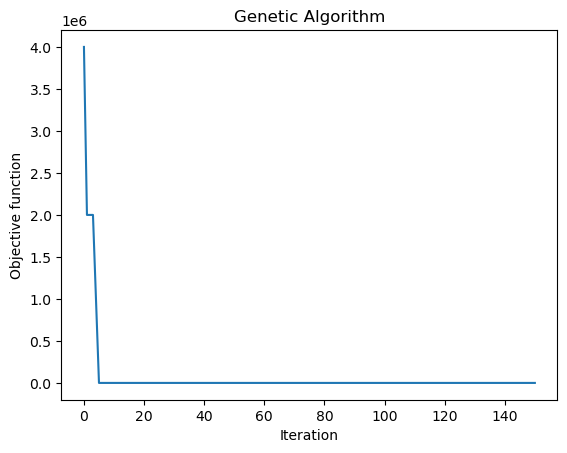

In [11]:
model = run_ga(type_matrix, temp_matrix, budget_max, type_to_num, tree_species)

ga_solution = [(int(model.output_dict['variable'][j]),
                  int(model.output_dict['variable'][j + 1]),
                  int(model.output_dict['variable'][j + 2]))
                 for j in range(0, len(model.output_dict['variable']), 4)
                 if int(model.output_dict['variable'][j + 3]) == 1]


In [12]:
print_solution_elements(ga_solution,heading='Single Run Result (25/75 Weighting)')
print("Total cost:", calculate_used_budget(ga_solution, type_matrix, tree_species, type_to_num))



--- Single Run Result (25/75 Weighting) ---
Number of placements: 20
Type: tree_1 at Position: (12, 8)
Type: tree_1 at Position: (19, 25)
Type: tree_1 at Position: (15, 2)
Type: tree_4 at Position: (19, 13)
Type: tree_4 at Position: (12, 20)
Type: tree_3 at Position: (4, 4)
Type: tree_2 at Position: (26, 6)
Type: tree_1 at Position: (24, 25)
Type: tree_4 at Position: (10, 14)
Type: tree_4 at Position: (11, 15)
Type: tree_1 at Position: (3, 28)
Type: tree_1 at Position: (13, 27)
Type: tree_2 at Position: (2, 12)
Type: tree_1 at Position: (10, 4)
Type: tree_1 at Position: (17, 14)
Type: tree_1 at Position: (14, 4)
Type: tree_2 at Position: (17, 8)
Type: tree_1 at Position: (3, 25)
Type: tree_1 at Position: (16, 14)
Type: tree_1 at Position: (18, 11)
Total cost: 1495.0


# Result GA

## Plot visualisation and comparation 

### Comparation with initial map

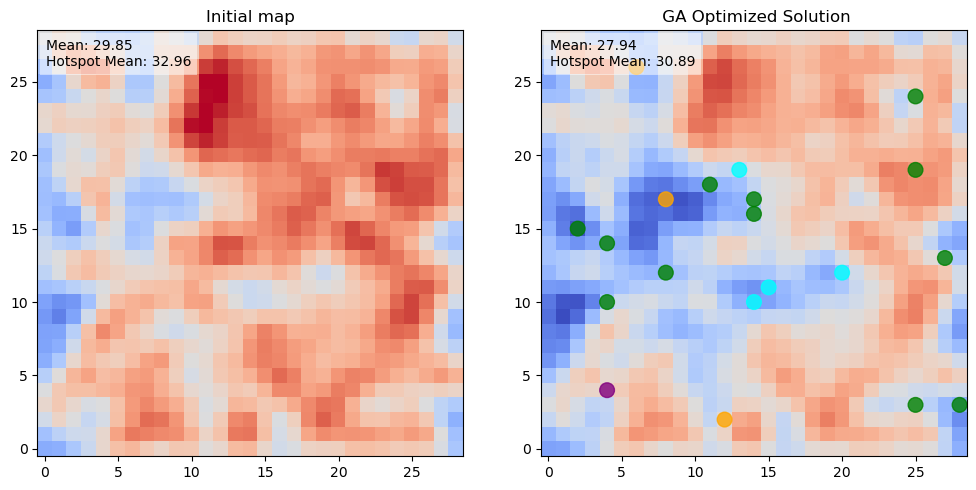

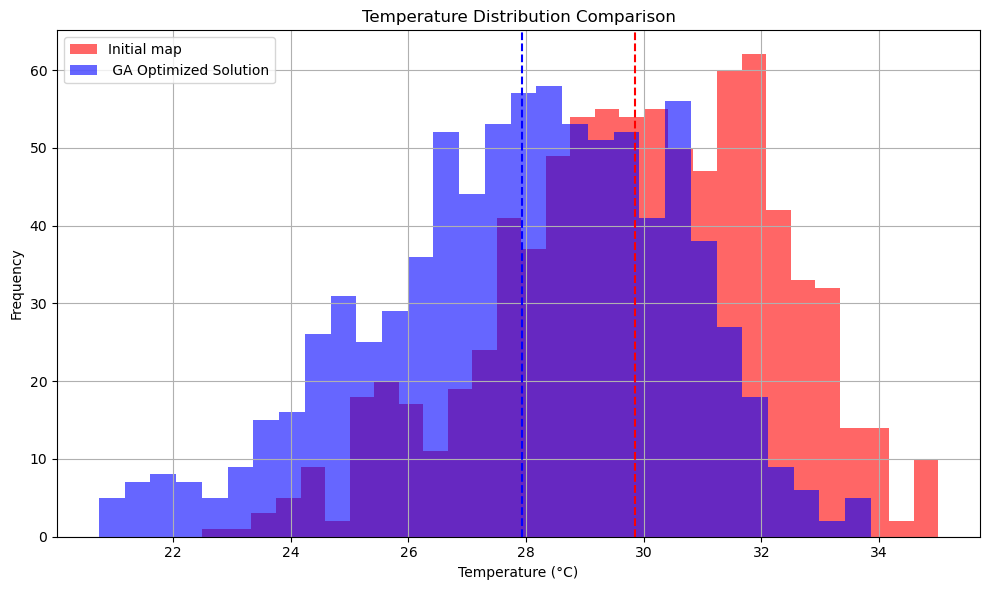

In [13]:
compare_solution_heatmaps([], ga_solution, temp_matrix, tree_species,
                          title1="Initial map", title2=" GA Optimized Solution")


### Comparation with random solution

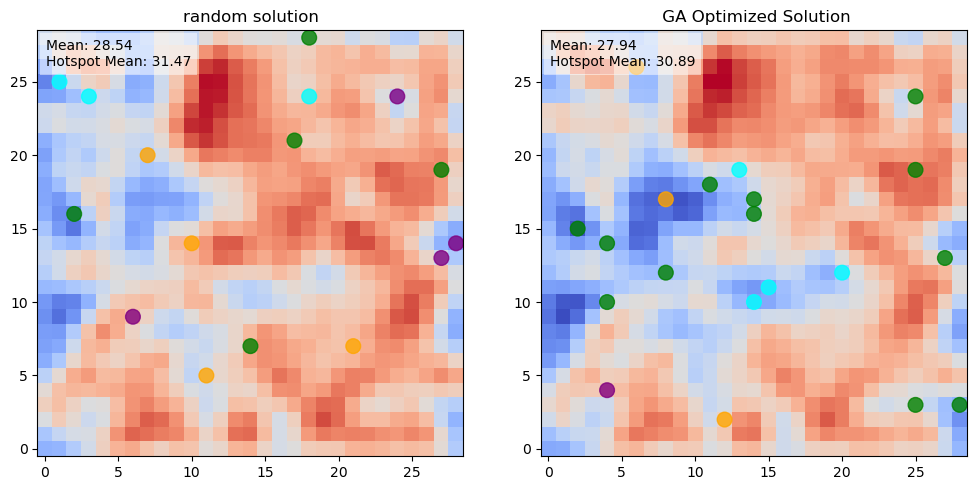

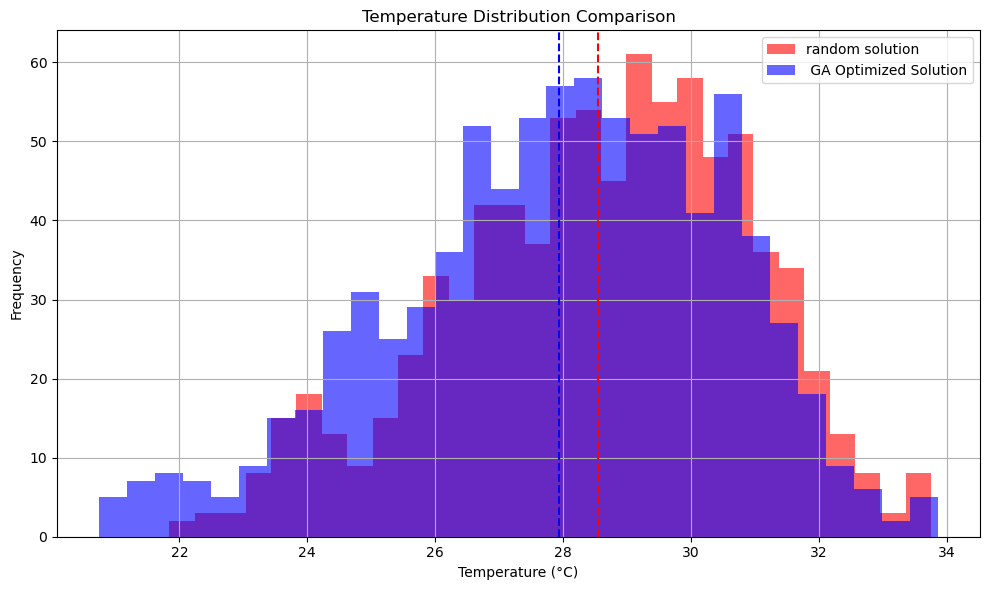

In [14]:
compare_solution_heatmaps(random_solution, ga_solution, temp_matrix, tree_species,
                          title1="random solution", title2=" GA Optimized Solution")

# ACO Result

## Plot visualisation and comparation

### Comparation with initial map

In [15]:
aco_solution = run_aco(type_matrix, temp_matrix, type_to_num, budget_max, iterations=100, num_ants=10)

In [16]:
print_solution_elements(aco_solution, heading='ACO Result')
print("Total cost:", calculate_used_budget(aco_solution, type_matrix, tree_species, type_to_num))
aco_heatmap = calculate_reduced_heatmap(aco_solution, temp_matrix, tree_species)


--- ACO Result ---
Number of placements: 18
Type: tree_3 at Position: (11, 20)
Type: tree_1 at Position: (21, 24)
Type: tree_1 at Position: (11, 1)
Type: tree_3 at Position: (3, 2)
Type: tree_1 at Position: (7, 12)
Type: tree_1 at Position: (11, 16)
Type: tree_2 at Position: (28, 2)
Type: tree_1 at Position: (14, 3)
Type: tree_2 at Position: (5, 13)
Type: tree_3 at Position: (10, 6)
Type: tree_1 at Position: (5, 24)
Type: tree_4 at Position: (1, 22)
Type: tree_2 at Position: (16, 1)
Type: tree_1 at Position: (27, 7)
Type: tree_2 at Position: (11, 19)
Type: tree_3 at Position: (24, 2)
Type: tree_2 at Position: (17, 6)
Type: tree_1 at Position: (12, 0)
Total cost: 1485.0


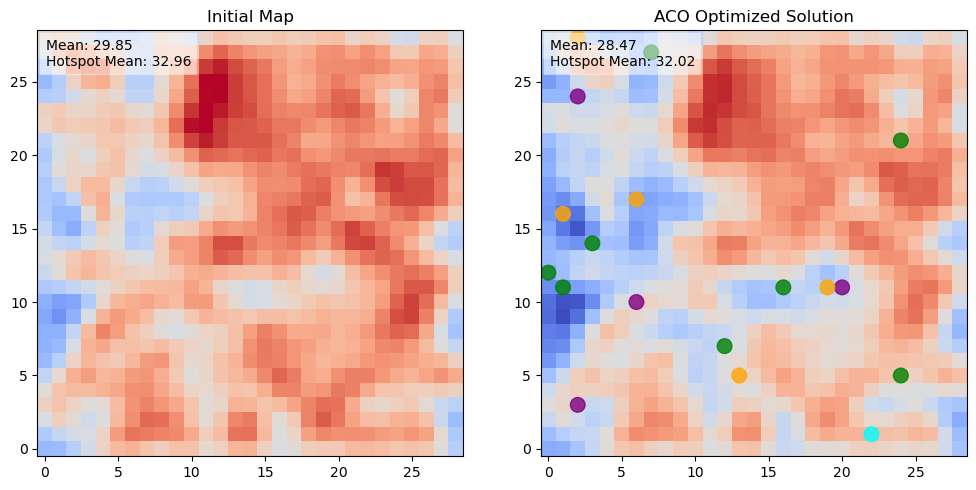

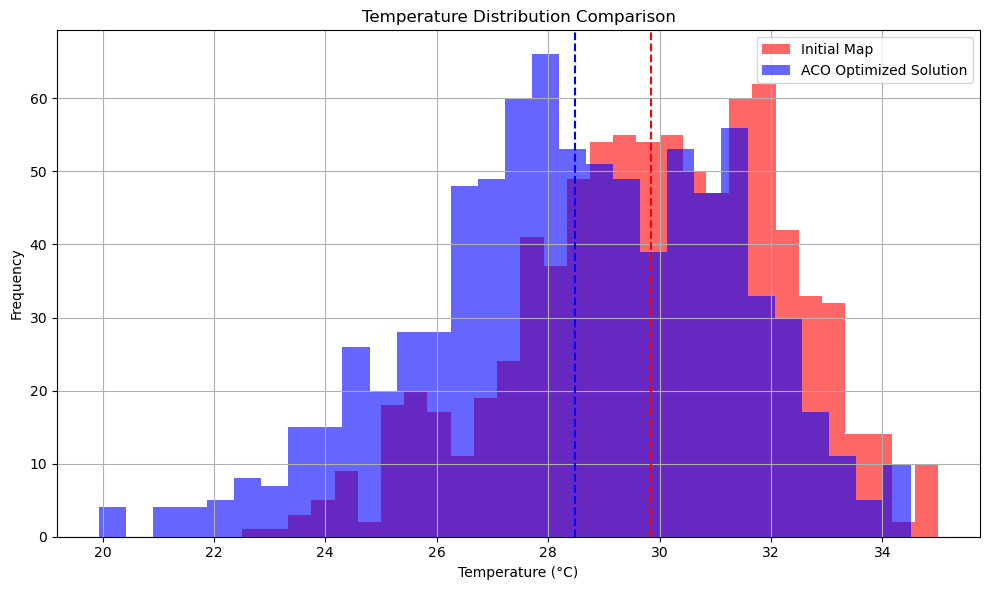

In [17]:
compare_solution_heatmaps([], aco_solution, temp_matrix, tree_species,
                          title1="Initial Map", title2="ACO Optimized Solution")


### Comparation with random solution

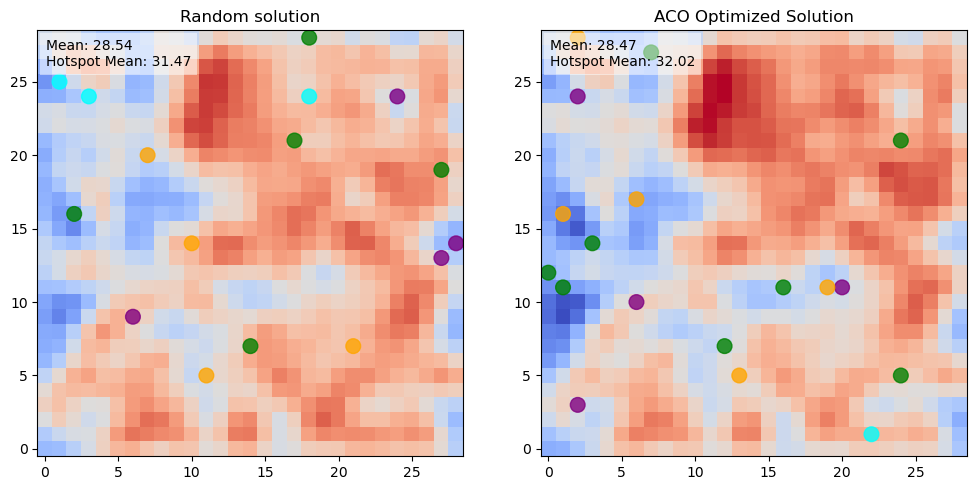

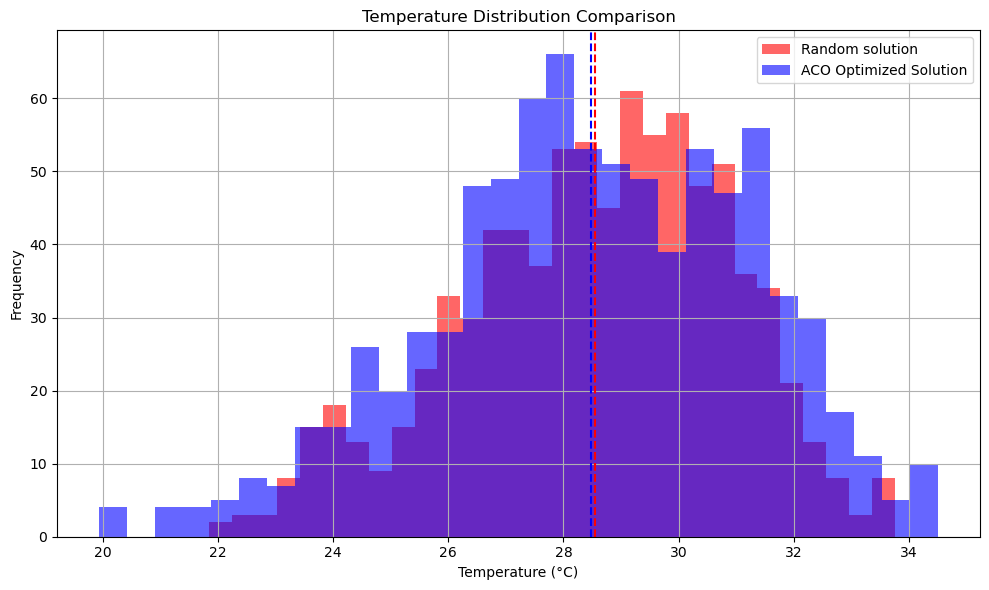

In [18]:
# Plot comparison of temperature maps for random_solution and ACO solutions
compare_solution_heatmaps(random_solution, aco_solution, temp_matrix, tree_species,
                          title1="Random solution", title2="ACO Optimized Solution")



# Comparation between GA and ACO

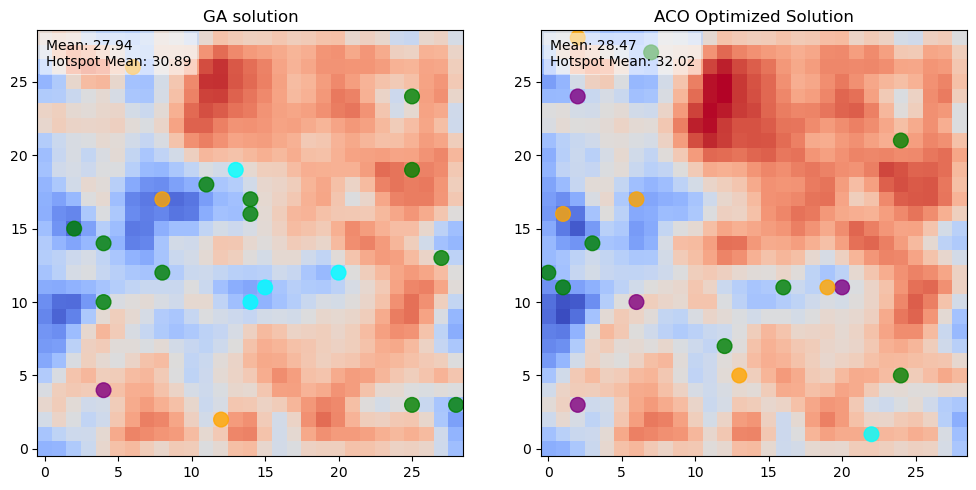

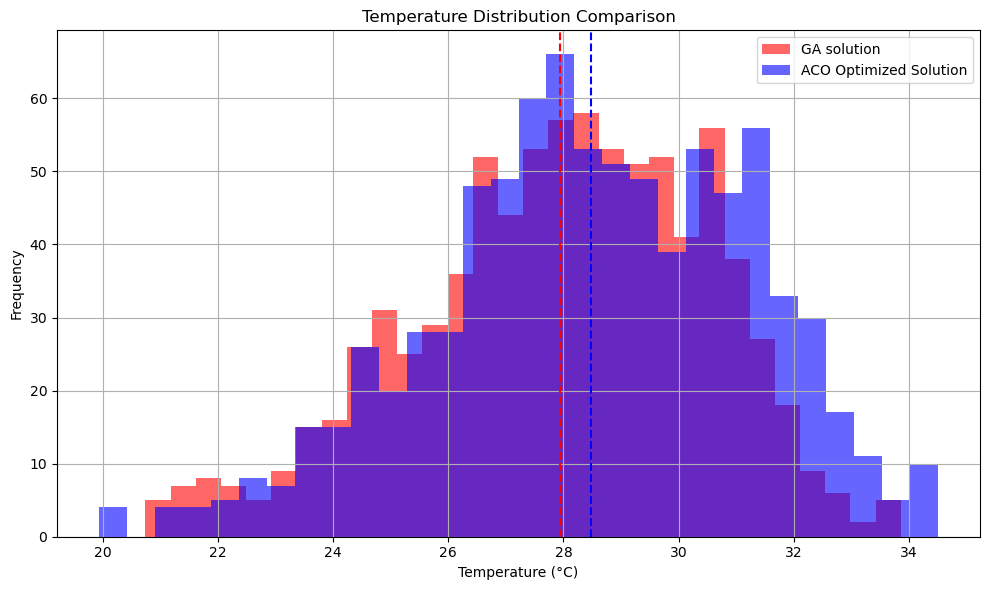

In [19]:
# Plot comparison of temperature maps for ga and ACO solutions
compare_solution_heatmaps(ga_solution, aco_solution, temp_matrix, tree_species,
                          title1="GA solution", title2="ACO Optimized Solution")

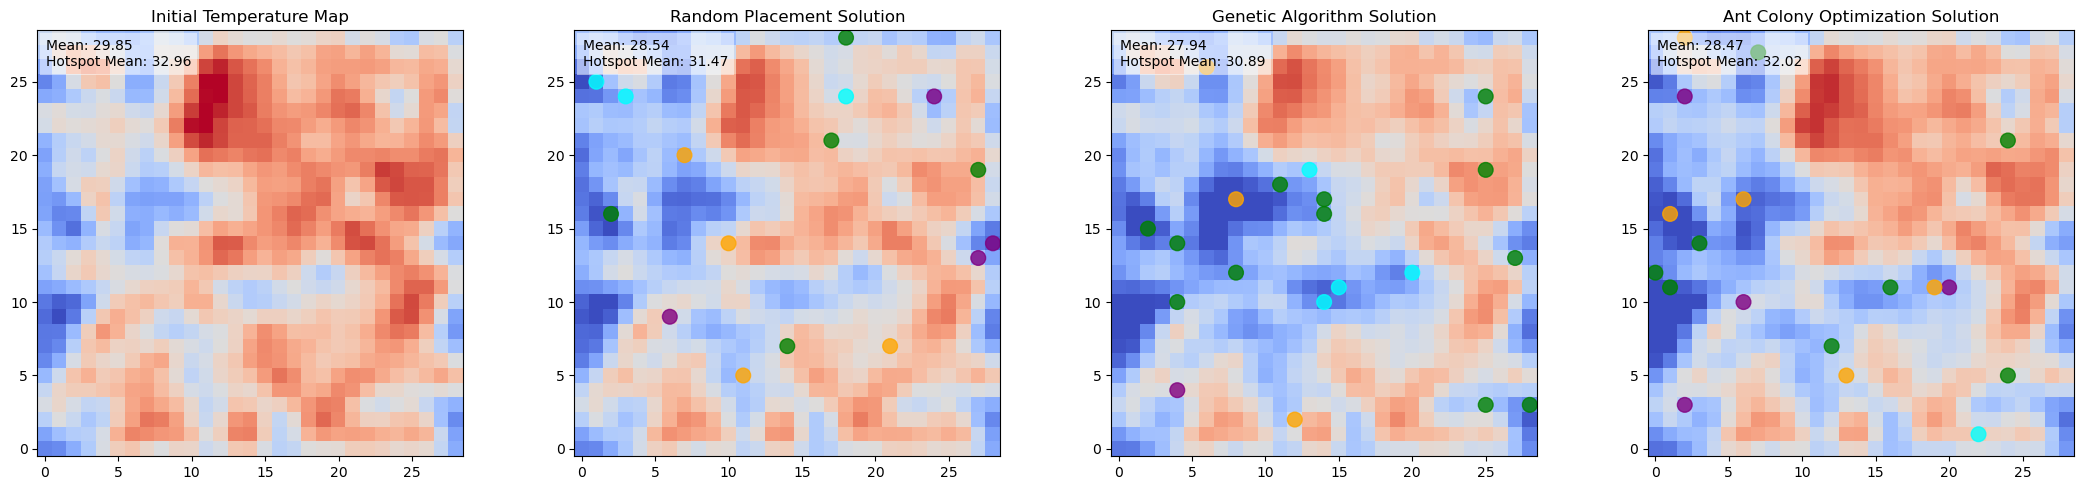

In [20]:
# Plot comparison of temperature maps for initial, random, GA, and ACO solutions
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Initial temperature map
generate_heatmap(temp_matrix, vmin=vmin, vmax=vmax, show=False, ax=axs[0])
avg_temp, avg_hotspot_temp = calculate_objective_stats(temp_matrix, temp_matrix)
axs[0].set_title("Initial Temperature Map")
axs[0].text(0.02, 0.98, f"Mean: {avg_temp:.2f}\nHotspot Mean: {avg_hotspot_temp:.2f}",
            transform=axs[0].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# Random solution temperature map
random_temp = calculate_reduced_heatmap(random_solution, temp_matrix, tree_species)
generate_heatmap(random_temp, vmin=vmin, vmax=vmax, show=False, ax=axs[1])
avg_temp, avg_hotspot_temp = calculate_objective_stats(random_temp, temp_matrix)
axs[1].set_title("Random Placement Solution")
axs[1].text(0.02, 0.98, f"Mean: {avg_temp:.2f}\nHotspot Mean: {avg_hotspot_temp:.2f}",
            transform=axs[1].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for (row, col, species) in random_solution:
    axs[1].add_patch(plt.Circle((col, row), radius=0.5, color=tree_species[species]['color'], alpha=0.8))

# GA solution temperature map
ga_temp = calculate_reduced_heatmap(ga_solution, temp_matrix, tree_species)
generate_heatmap(ga_temp, vmin=vmin, vmax=vmax, show=False, ax=axs[2])
avg_temp, avg_hotspot_temp = calculate_objective_stats(ga_temp, temp_matrix)
axs[2].set_title("Genetic Algorithm Solution")
axs[2].text(0.02, 0.98, f"Mean: {avg_temp:.2f}\nHotspot Mean: {avg_hotspot_temp:.2f}",
            transform=axs[2].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for (row, col, species) in ga_solution:
    axs[2].add_patch(plt.Circle((col, row), radius=0.5, color=tree_species[species]['color'], alpha=0.8))

# ACO solution temperature map
aco_temp = calculate_reduced_heatmap(aco_solution, temp_matrix, tree_species)
generate_heatmap(aco_temp, vmin=vmin, vmax=vmax, show=False, ax=axs[3])
avg_temp, avg_hotspot_temp = calculate_objective_stats(aco_temp, temp_matrix)
axs[3].set_title("Ant Colony Optimization Solution")
axs[3].text(0.02, 0.98, f"Mean: {avg_temp:.2f}\nHotspot Mean: {avg_hotspot_temp:.2f}",
            transform=axs[3].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for (row, col, species) in aco_solution:
    axs[3].add_patch(plt.Circle((col, row), radius=0.5, color=tree_species[species]['color'], alpha=0.8))

plt.tight_layout()
plt.show()

# Multi-Run result


--- Run 1 ---
Random   → budget 1475.0, avg 28.52, hotspot 31.96, trees 16, time 0.000s
 The best solution found:                                                                           
 [ 8. 10.  1.  0. 21.  9.  3.  0.  0. 15.  1.  0.  9. 17.  3.  0. 15. 24.
  0.  1. 23.  6.  0.  1. 18. 16.  2.  1.  4. 25.  2.  0. 28.  2.  1.  0.
 15. 20.  2.  0.  5.  1.  2.  0.  8.  2.  2.  0. 22.  8.  3.  0.  4. 26.
  1.  0.  9.  3.  0.  1. 25.  1.  1.  1. 26.  1.  3.  0. 26. 26.  2.  0.
 16. 22.  3.  1.  7.  3.  0.  0. 19.  6.  0.  0. 10. 24.  1.  0.  5.  1.
  2.  0. 18. 17.  3.  0. 14.  7.  3.  0.  8. 27.  0.  0. 14. 12.  0.  0.
 13.  8.  2.  0.  9. 17.  3.  1.  4. 11.  1.  0. 23.  7.  0.  1. 16. 17.
  1.  0. 26. 11.  2.  0. 11. 10.  3.  0. 17. 11.  0.  1. 12. 16.  0.  0.
 12. 22.  0.  1. 17.  0.  0.  0. 16. 11.  2.  1. 15. 19.  3.  1. 12.  8.
  0.  1. 28. 10.  0.  1. 15. 23.  0.  1. 16. 21.  0.  1. 15. 20.  2.  0.
 12.  4.  1.  0. 10.  2.  2.  0. 17. 21.  0.  1.  8.  6.  0.  1. 24.  4.
  1.  

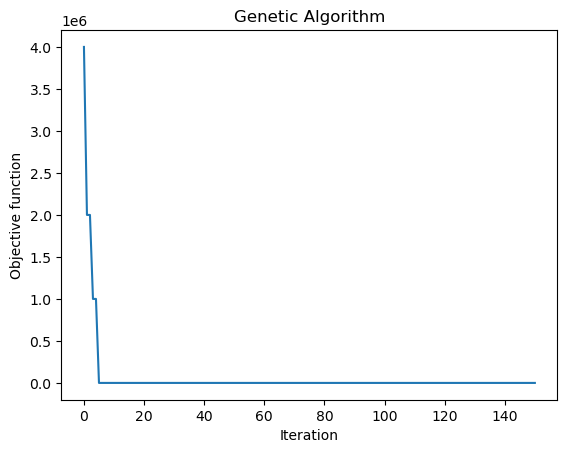

GA       → budget 1475.0, avg 28.00, hotspot 30.28, trees 18, time 134.412s
ACO      → budget 1500.0, avg 28.47, hotspot 31.98, trees 18, time 15.634s
ACO+Cand → budget 1460.0, avg 28.46, hotspot 31.64, trees 18, time 16.062s

--- Run 2 ---
Random   → budget 1470.0, avg 28.69, hotspot 31.70, trees 15, time 0.000s
 The best solution found:                                                                           
 [25. 16.  0.  1. 20. 16.  3.  0.  0. 11.  2.  1.  4.  8.  2.  0.  2.  4.
  1.  0. 15. 12.  0.  0. 17.  9.  0.  1. 14. 28.  2.  1. 16.  6.  1.  0.
  1. 25.  0.  0. 15.  9.  0.  1.  5. 18.  1.  0. 17. 13.  1.  0. 14. 16.
  3.  1. 18.  7.  0.  1.  2. 27.  2.  0. 17.  8.  0.  1.  5. 22.  1.  0.
 18. 11.  0.  0. 17. 18.  3.  0. 17. 20.  0.  1.  3. 28.  1.  0. 23. 20.
  1.  0. 21. 12.  0.  0. 10.  6.  0.  0.  1. 20.  1.  0.  7. 22.  2.  0.
 10. 15.  0.  1. 17. 13.  0.  0.  4. 20.  2.  0.  8. 14.  2.  0. 24. 16.
  0.  1.  8.  8.  3.  1.  9. 11.  0.  1. 23.  4.  2.  0. 21. 18.  0.  1.

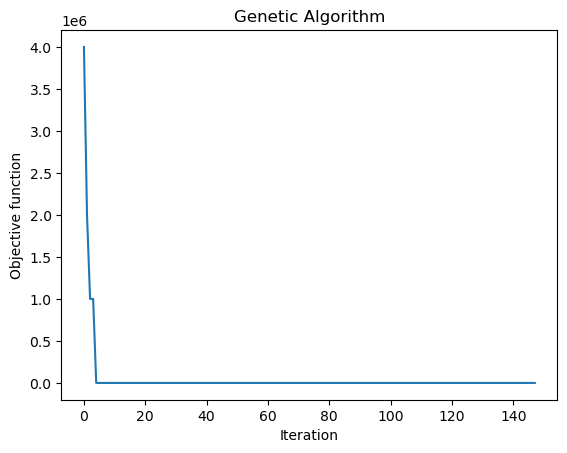


ACO      → budget 1500.0, avg 28.49, hotspot 31.54, trees 17, time 14.840s
ACO+Cand → budget 1480.0, avg 28.51, hotspot 32.12, trees 18, time 14.677s

--- Run 3 ---
Random   → budget 1485.0, avg 28.66, hotspot 31.97, trees 15, time 0.000s
 The best solution found:                                                                           
 [18. 14.  0.  1. 19.  6.  0.  0. 15. 11.  3.  1.  2. 12.  1.  0.  8. 19.
  0.  1. 16.  1.  3.  0. 17. 15.  1.  1. 10. 23.  0.  0.  7. 12.  2.  1.
 20.  0.  2.  1. 19.  9.  3.  0.  4. 16.  0.  0. 19. 16.  0.  1. 10. 18.
  3.  0. 21. 18.  0.  1.  4. 11.  0.  0.  6. 10.  0.  1.  9. 12.  1.  0.
  2.  0.  3.  0.  8. 24.  1.  0. 23. 18.  2.  0. 11. 23.  2.  0. 27. 10.
  0.  1. 11. 14.  2.  0. 12.  2.  3.  0. 18. 21.  3.  0. 11.  5.  0.  1.
 13. 11.  1.  0. 17. 25.  2.  0. 14.  7.  3.  1.  7. 25.  2.  0. 17. 25.
  0.  0.  4.  0.  1.  0. 21. 19.  1.  1. 15. 12.  2.  0.  7. 26.  3.  0.
 23. 10.  2.  0. 28. 14.  3.  1. 19.  0.  0.  1. 11.  0.  2.  0. 13. 13.
 

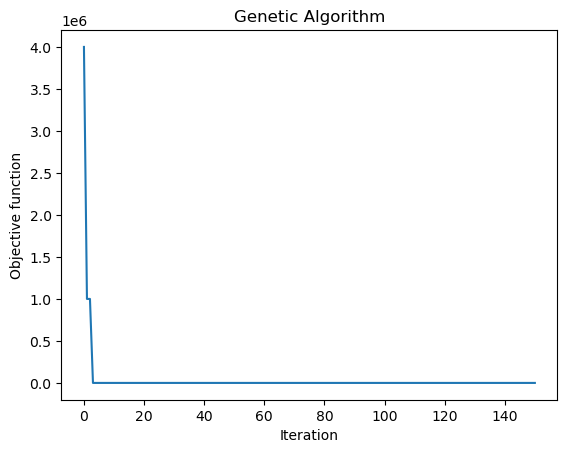

GA       → budget 1495.0, avg 28.11, hotspot 30.87, trees 18, time 127.153s
ACO      → budget 1495.0, avg 28.35, hotspot 31.75, trees 18, time 14.014s
ACO+Cand → budget 1485.0, avg 28.31, hotspot 31.61, trees 18, time 14.292s

--- Run 4 ---
Random   → budget 1495.0, avg 28.84, hotspot 31.99, trees 13, time 0.000s
 The best solution found:                                                                           
 [ 7.  9.  2.  0. 28. 12.  3.  0.  1.  4.  3.  0.  2.  1.  1.  1. 25. 27.
  3.  0. 10.  8.  2.  0. 18. 22.  0.  1. 22. 16.  0.  1. 28. 10.  3.  1.
 21. 13.  0.  0.  2.  2.  3.  0. 14. 18.  3.  1.  2. 14.  3.  0. 28.  3.
  3.  0. 14. 13.  1.  0. 20. 21.  0.  0. 14. 26.  0.  0.  6.  9.  3.  0.
  1.  0.  3.  0. 18. 19.  2.  0. 17.  4.  0.  0. 25.  1.  2.  0.  0.  7.
  1.  0. 23. 23.  0.  1. 11. 25.  3.  0. 17. 17.  2.  1.  7.  5.  2.  0.
 28. 20.  1.  0. 28.  1.  3.  0. 15. 19.  0.  1. 13.  1.  0.  1. 20. 12.
  1.  0.  2. 16.  0.  1. 20.  2.  2.  1.  3.  9.  2.  0. 18. 28.  0.  1.

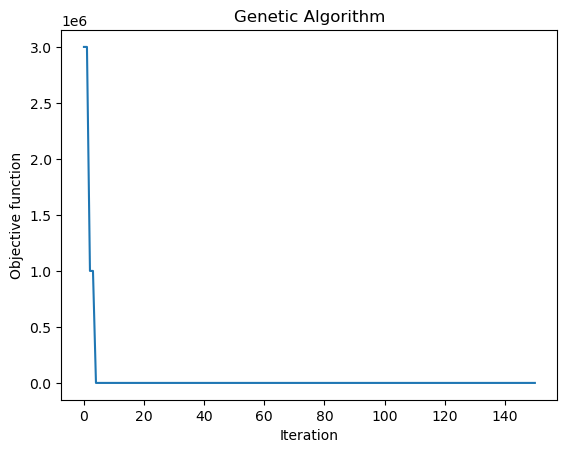

GA       → budget 1490.0, avg 28.14, hotspot 29.86, trees 18, time 127.980s
ACO      → budget 1500.0, avg 28.38, hotspot 31.83, trees 18, time 14.207s
ACO+Cand → budget 1465.0, avg 28.43, hotspot 31.80, trees 18, time 14.266s

--- Run 5 ---
Random   → budget 1480.0, avg 28.81, hotspot 32.25, trees 14, time 0.000s
 The best solution found:                                                                           
 [17. 17.  2.  0. 10. 23.  1.  1. 20. 19.  0.  1. 17. 26.  0.  1. 15.  7.
  3.  1. 16. 19.  0.  1.  4. 27.  1.  0. 21.  2.  1.  0. 13. 19.  3.  1.
  9. 18.  1.  0.  3.  1.  1.  0. 15. 24.  1.  1. 17.  2.  1.  0.  3. 16.
  2.  0.  8.  9.  3.  1.  7. 26.  1.  0. 28.  0.  0.  0. 21. 12.  0.  0.
  0. 25.  3.  0.  7. 12.  3.  0. 25. 25.  0.  0.  7.  2.  0.  0. 12.  0.
  2.  0. 21. 17.  0.  1. 16.  8.  0.  1. 23. 18.  3.  0.  8. 11.  0.  1.
 19.  2.  3.  0.  3. 12.  3.  0. 11. 13.  2.  1. 26.  9.  1.  0. 19.  6.
  1.  0. 17. 11.  0.  0. 15.  7.  2.  0. 22. 13.  0.  1. 18.  7.  0.  0.

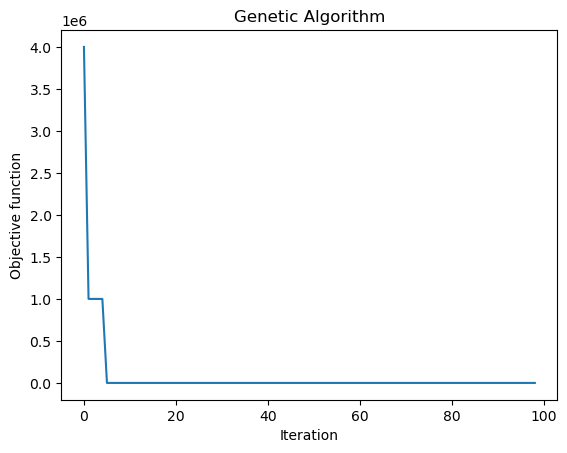


ACO      → budget 1495.0, avg 28.54, hotspot 31.96, trees 18, time 14.053s
ACO+Cand → budget 1480.0, avg 28.35, hotspot 32.00, trees 19, time 15.002s

--- Run 6 ---
Random   → budget 1495.0, avg 28.56, hotspot 31.63, trees 12, time 0.000s
 The best solution found:                                                                           
 [11. 16.  0.  1.  5. 19.  0.  1. 20. 11.  1.  0.  7. 19.  2.  0. 17. 21.
  0.  1. 19. 21.  0.  1. 12. 23.  1.  0. 24.  7.  1.  0. 11.  6.  1.  0.
 24. 26.  1.  0.  9. 10.  3.  0. 18.  6.  2.  0. 16. 27.  0.  0. 18.  0.
  0.  1. 21. 21.  0.  1. 17. 20.  2.  1. 20. 17.  0.  1. 27. 10.  0.  0.
 23. 25.  0.  1. 28. 28.  0.  0. 15. 19.  3.  1.  0.  5.  1.  0. 20. 21.
  1.  0. 15. 24.  1.  1. 11. 17.  1.  0. 26.  9.  0.  1. 24.  0.  3.  0.
 11. 15.  1.  1.  9. 10.  2.  0. 28. 12.  2.  0. 19. 16.  0.  1. 20. 19.
  1.  0. 17. 26.  0.  1. 21.  6.  2.  0. 13. 24.  1.  0. 27. 21.  0.  1.
 16.  0.  0.  0. 26. 23.  3.  0.  9. 15.  3.  0. 14. 18.  0.  1. 13. 26.
 

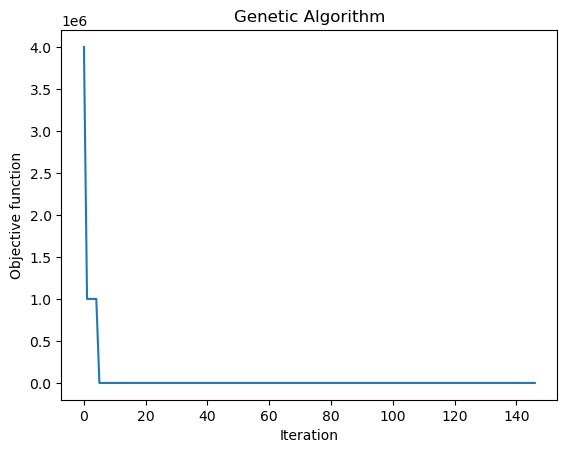


ACO      → budget 1500.0, avg 28.59, hotspot 31.48, trees 17, time 14.092s
ACO+Cand → budget 1480.0, avg 28.42, hotspot 31.52, trees 18, time 13.798s

--- Run 7 ---
Random   → budget 1495.0, avg 28.57, hotspot 31.81, trees 16, time 0.000s
 The best solution found:                                                                           
 [20. 22.  3.  1. 25. 15.  1.  0. 13. 17.  3.  1. 19. 25.  0.  1.  5.  4.
  1.  0.  7.  8.  3.  0. 11. 20.  3.  1. 22. 15.  0.  1. 10.  5.  0.  0.
  8. 13.  2.  0. 17. 26.  2.  0. 27. 22.  1.  0.  5. 10.  3.  0. 18.  6.
  0.  1. 13. 13.  1.  0. 22. 13.  3.  1.  4.  9.  1.  0. 13. 11.  0.  0.
  9.  7.  1.  0. 27.  7.  0.  1. 22.  9.  2.  0. 12.  6.  3.  0. 18. 11.
  0.  1. 14. 27.  2.  0.  3.  5.  3.  0. 20. 23.  3.  0. 23. 15.  2.  0.
  8. 19.  2.  0. 16. 23.  0.  1. 11.  6.  2.  1.  8. 19.  0.  0.  3. 13.
  2.  0. 27.  8.  3.  0. 12. 16.  3.  0. 10. 27.  3.  0. 19. 19.  3.  1.
 27. 14.  0.  0. 23. 20.  1.  0. 27. 25.  0.  0.  7. 17.  3.  0.  3.  4.
 

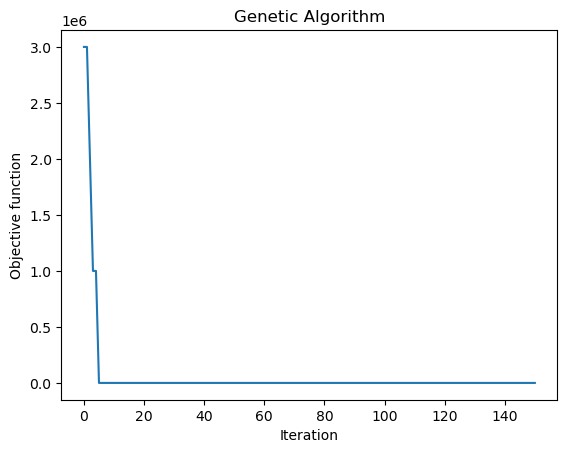

GA       → budget 1500.0, avg 28.19, hotspot 30.36, trees 15, time 123.341s
ACO      → budget 1500.0, avg 28.35, hotspot 31.72, trees 17, time 14.057s
ACO+Cand → budget 1485.0, avg 28.35, hotspot 31.42, trees 18, time 14.856s

--- Run 8 ---
Random   → budget 1490.0, avg 28.52, hotspot 31.66, trees 15, time 0.000s
 The best solution found:                                                                           
 [10. 21.  2.  0. 12. 14.  1.  0. 25.  8.  0.  1.  9. 21.  1.  0. 10.  4.
  2.  0.  6. 21.  0.  0. 27.  3.  1.  0. 10. 25.  1.  0.  6. 16.  0.  1.
 27. 20.  3.  0.  7. 21.  0.  1. 17.  1.  1.  0.  6. 22.  0.  1. 22. 25.
  1.  0.  7.  3.  2.  0. 23. 19.  0.  1. 19. 16.  3.  1. 22.  6.  0.  0.
 13. 20.  2.  0.  0.  4.  2.  0.  3.  4.  2.  0. 12. 12.  1.  1. 19.  9.
  0.  1.  1.  6.  1.  0. 23. 10.  2.  0. 11.  9.  0.  1. 16. 21.  2.  0.
 16.  8.  0.  0. 17. 20.  3.  1.  3.  5.  3.  0. 25. 17.  0.  1. 20. 27.
  2.  0.  6. 18.  1.  0. 19. 20.  1.  1. 21. 13.  0.  0. 21. 26.  1.  0.

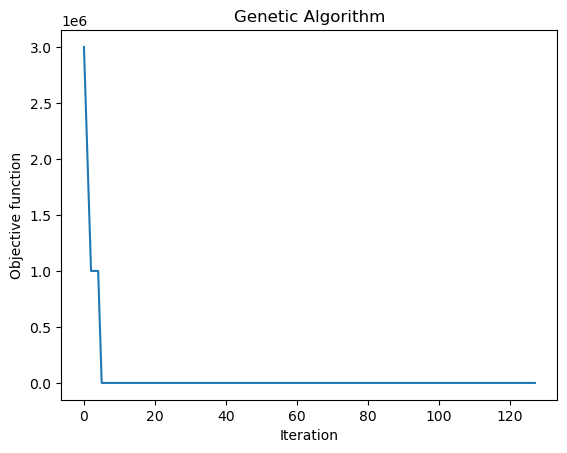


ACO      → budget 1485.0, avg 28.46, hotspot 31.80, trees 18, time 13.747s
ACO+Cand → budget 1490.0, avg 28.28, hotspot 31.43, trees 18, time 14.137s

--- Run 9 ---
Random   → budget 1475.0, avg 28.73, hotspot 31.91, trees 15, time 0.000s
 The best solution found:                                                                           
 [ 8.  5.  0.  0. 19. 20.  0.  1. 12. 12.  1.  0.  7. 16.  0.  0. 13. 22.
  0.  0. 25. 22.  0.  1.  5.  7.  0.  0.  4. 28.  0.  0.  4. 13.  1.  0.
  4.  7.  0.  1. 22.  8.  0.  1. 16. 20.  1.  0. 18. 16.  2.  1. 14. 10.
  3.  1. 13. 20.  3.  1.  7.  1.  0.  0. 24.  3.  0.  1. 18.  0.  1.  0.
  3. 13.  3.  0.  9. 21.  0.  0. 21. 21.  3.  0.  5.  7.  3.  0.  4. 14.
  0.  1.  5.  3.  2.  0.  0. 13.  0.  0.  4. 14.  0.  0.  5. 21.  3.  0.
  6.  3.  1.  0. 21.  4.  3.  1. 11. 19.  0.  1. 17. 13.  1.  0. 10.  2.
  0.  0. 19. 15.  0.  1. 26. 21.  1.  0.  7.  4.  2.  0. 18.  6.  0.  0.
 23. 16.  3.  1.  7.  1.  2.  0. 18.  0.  0.  0.  9.  9.  1.  1. 16. 11.
 

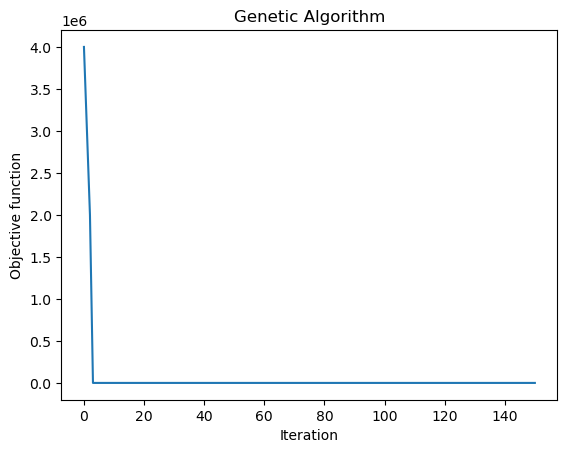

GA       → budget 1490.0, avg 28.00, hotspot 30.60, trees 17, time 121.984s
ACO      → budget 1490.0, avg 28.54, hotspot 31.93, trees 19, time 13.959s
ACO+Cand → budget 1490.0, avg 28.34, hotspot 31.67, trees 19, time 13.873s

--- Run 10 ---
Random   → budget 1460.0, avg 28.63, hotspot 31.70, trees 16, time 0.000s
 The best solution found:                                                                           
 [ 4.  7.  2.  0.  0. 19.  1.  1.  3. 12.  0.  0. 17.  5.  2.  1. 17. 13.
  0.  0. 19. 16.  0.  0. 16. 20.  1.  0. 11. 17.  0.  1. 15. 11.  2.  0.
 18.  9.  3.  0. 13. 28.  3.  0.  3. 21.  0.  0.  6.  0.  0.  1. 13. 18.
  0.  1. 19. 20.  0.  1. 12. 18.  3.  0. 26. 11.  1.  0. 28. 23.  0.  0.
  1.  1.  0.  1. 17. 28.  0.  0. 22.  6.  3.  0. 15. 24.  0.  1. 13. 11.
  3.  0.  1. 23.  2.  0. 19. 16.  0.  1.  9.  9.  1.  1. 27.  8.  2.  0.
 26.  8.  0.  0. 24. 14.  0.  1. 10. 10.  2.  0. 26. 16.  0.  0.  5. 16.
  3.  0. 12. 16.  2.  0.  2.  5.  2.  0.  4.  7.  1.  1. 19. 10.  1.  1

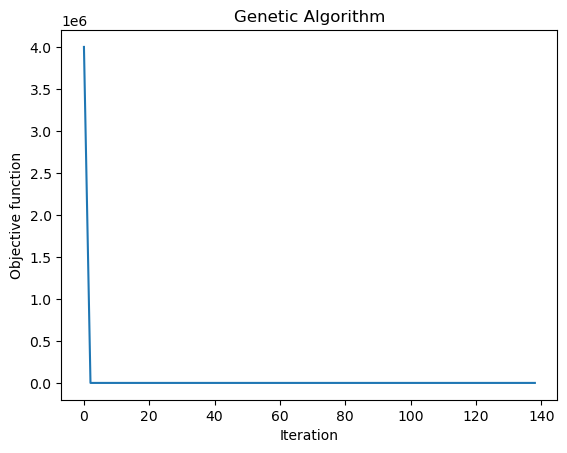


ACO      → budget 1455.0, avg 28.47, hotspot 31.45, trees 17, time 13.538s
ACO+Cand → budget 1480.0, avg 28.25, hotspot 31.26, trees 18, time 14.232s

--- Run 11 ---
Random   → budget 1490.0, avg 28.64, hotspot 31.70, trees 13, time 0.000s
 The best solution found:                                                                           
 [21.  6.  1.  0. 24. 14.  2.  1. 17. 26.  3.  0.  5. 15.  0.  0. 20. 17.
  2.  0. 12. 19.  0.  1.  5.  8.  2.  0. 15. 19.  3.  1. 15. 14.  0.  1.
 21. 19.  0.  1. 26. 25.  3.  0. 17. 24.  2.  1. 11. 17.  1.  0. 12.  2.
  0.  0. 18. 18.  0.  1. 20.  8.  2.  1. 20. 19.  3.  1. 12. 23.  0.  1.
 25. 28.  1.  0. 26. 17.  0.  1.  1. 15.  1.  0. 15. 13.  1.  0. 13.  3.
  0.  0. 19. 13.  0.  1.  4. 23.  2.  0.  8. 22.  0.  1. 28. 22.  2.  0.
 21.  8.  1.  0. 15. 16.  2.  0. 21. 21.  2.  0.  8.  7.  1.  0. 16.  0.
  1.  0.  3. 22.  2.  0. 24. 26.  3.  0. 22. 17.  0.  0. 14. 22.  2.  0.
 11. 19.  2.  0.  5.  3.  0.  0. 24.  2.  2.  0. 15. 27.  0.  0. 11. 16.


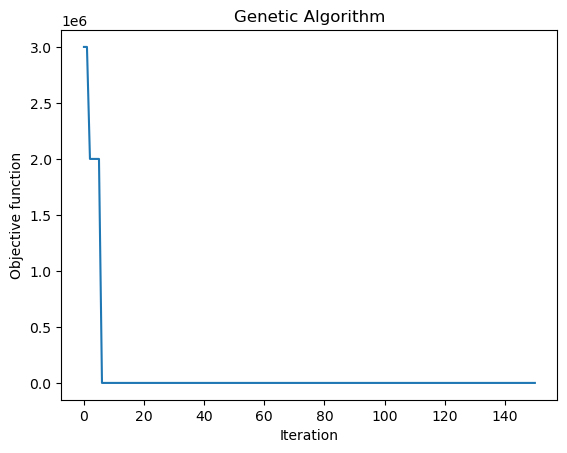

GA       → budget 1485.0, avg 28.16, hotspot 30.15, trees 17, time 121.931s
ACO      → budget 1470.0, avg 28.42, hotspot 31.46, trees 17, time 13.342s
ACO+Cand → budget 1500.0, avg 28.38, hotspot 31.57, trees 18, time 13.785s

--- Run 12 ---
Random   → budget 1480.0, avg 28.69, hotspot 32.05, trees 15, time 0.000s
 The best solution found:                                                                           
 [10.  6.  2.  0. 13.  8.  1.  0. 17. 26.  1.  0.  9. 27.  2.  1.  7.  1.
  3.  0.  7. 21.  2.  0. 16.  2.  0.  1. 22. 21.  0.  1. 11. 20.  0.  1.
 23. 23.  3.  1. 12. 26.  3.  0. 26. 17.  1.  0. 15. 21.  0.  0. 10. 22.
  0.  1. 19. 11.  1.  1. 15. 28.  2.  1.  1.  1.  2.  0. 22. 16.  1.  0.
 21. 18.  2.  1. 20. 12.  1.  0.  4. 14.  1.  0. 23. 21.  0.  0. 25. 16.
  2.  0. 28. 12.  2.  0. 12. 23.  0.  1. 22.  0.  1.  0.  9. 14.  0.  0.
 26. 26.  0.  0.  7. 27.  1.  0. 18. 14.  2.  1. 20. 22.  0.  1.  2.  3.
  2.  0. 18. 26.  2.  0.  2.  2.  0.  0. 18.  1.  2.  0. 14. 27.  0.  0

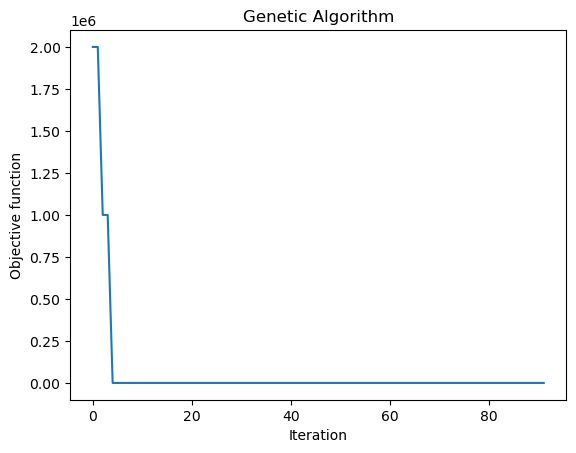


ACO      → budget 1465.0, avg 28.46, hotspot 32.04, trees 17, time 13.518s
ACO+Cand → budget 1470.0, avg 28.39, hotspot 31.83, trees 18, time 13.634s

--- Run 13 ---
Random   → budget 1490.0, avg 28.59, hotspot 31.72, trees 17, time 0.000s
 The best solution found:                                                                           
 [24. 24.  0.  1. 27.  7.  1.  0. 23. 25.  2.  0. 17. 24.  0.  1. 23. 16.
  0.  1. 15.  8.  0.  1. 10. 15.  3.  1.  3. 13.  3.  0.  5. 13.  1.  0.
 13.  3.  1.  0.  8. 11.  3.  0.  7. 19.  2.  0. 12. 12.  1.  0. 16. 13.
  0.  1. 11.  6.  1.  1.  7. 25.  3.  0. 16. 23.  1.  0. 17. 21.  0.  1.
  7.  0.  3.  0. 13. 19.  3.  1. 25.  8.  0.  0.  7. 28.  0.  1. 21.  9.
  1.  0. 13. 27.  1.  0. 25.  9.  0.  0.  2. 20.  3.  0.  1. 24.  2.  0.
  6. 17.  2.  0. 10. 28.  0.  1.  8. 10.  0.  0.  5. 25.  3.  0. 24. 17.
  1.  1. 12.  3.  2.  0. 18. 16.  0.  1.  7. 12.  0.  1. 26.  7.  1.  0.
 12.  2.  2.  0. 27.  2.  3.  0.  6.  0.  3.  1. 13. 22.  3.  1.  4.  5.


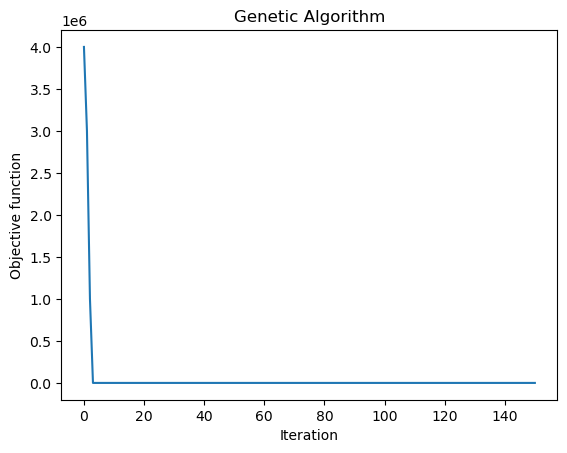

GA       → budget 1500.0, avg 27.99, hotspot 30.29, trees 19, time 122.142s
ACO      → budget 1480.0, avg 28.36, hotspot 31.79, trees 19, time 13.847s
ACO+Cand → budget 1490.0, avg 28.46, hotspot 31.69, trees 18, time 14.424s

--- Run 14 ---
Random   → budget 1460.0, avg 28.69, hotspot 31.83, trees 15, time 0.000s
 The best solution found:                                                                           
 [19. 15.  2.  0. 24. 13.  2.  0. 16. 16.  0.  1. 18.  7.  0.  1.  2. 10.
  0.  0. 16. 21.  0.  0. 10.  4.  0.  1. 17.  9.  1.  0. 17. 11.  2.  1.
 20. 10.  3.  0. 10. 27.  0.  0. 19. 20.  0.  1. 27.  4.  0.  1.  7. 20.
  1.  1. 25. 19.  1.  1.  0.  5.  2.  0. 15.  3.  0.  0. 10. 20.  0.  1.
 16. 22.  2.  1. 28. 14.  0.  0. 23. 12.  1.  0. 15.  8.  0.  1. 26.  3.
  2.  0. 12. 21.  0.  1. 11. 15.  3.  0. 25. 22.  1.  1. 14.  5.  2.  0.
 24.  7.  1.  0.  1. 15.  2.  0. 13.  8.  2.  0. 14.  7.  2.  1.  3.  3.
  0.  0. 15.  5.  3.  0. 23. 24.  0.  0. 28.  4.  3.  0. 22.  4.  2.  0

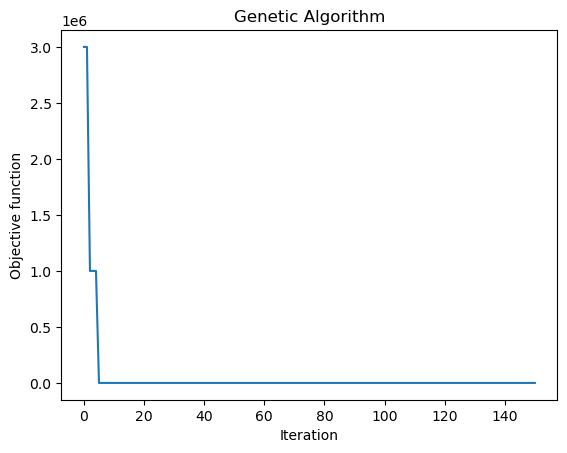

GA       → budget 1475.0, avg 28.06, hotspot 30.74, trees 19, time 122.661s
ACO      → budget 1495.0, avg 28.37, hotspot 31.86, trees 17, time 13.297s
ACO+Cand → budget 1480.0, avg 28.44, hotspot 31.75, trees 19, time 14.124s

--- Run 15 ---
Random   → budget 1490.0, avg 28.76, hotspot 31.84, trees 14, time 0.000s
 The best solution found:                                                                           
 [15. 13.  0.  1. 23. 19.  0.  0. 20. 25.  0.  1. 26. 28.  2.  0. 10. 16.
  2.  1. 10. 21.  0.  1. 10.  1.  3.  0.  8. 10.  2.  0. 26.  7.  0.  0.
 25. 20.  1.  0. 11.  2.  2.  0. 10. 23.  0.  1.  7. 24.  0.  0.  8. 10.
  2.  0. 19. 11.  2.  1.  4. 27.  2.  0. 23. 25.  1.  1. 18.  1.  0.  0.
 11.  3.  0.  1. 25. 22.  0.  1.  1. 12.  2.  0.  4. 16.  1.  0. 10. 14.
  0.  1.  5.  8.  1.  0. 18. 15.  3.  0. 21. 23.  0.  1. 21. 25.  0.  0.
 12. 28.  2.  1. 18. 28.  2.  0.  0.  8.  0.  1.  6. 23.  2.  0.  6.  5.
  3.  0. 16. 16.  0.  1. 12. 20.  0.  1. 14. 14.  1.  0. 24. 18.  0.  0

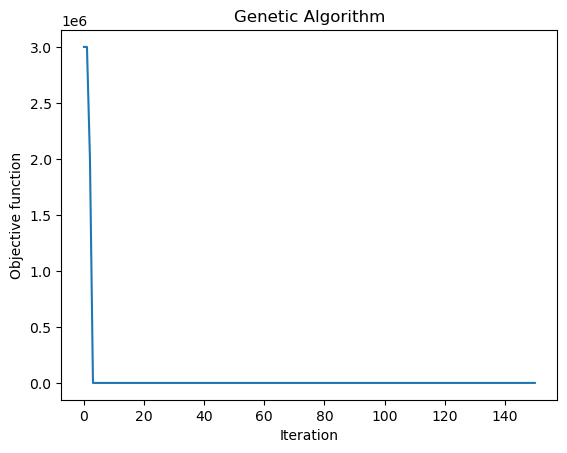

GA       → budget 1490.0, avg 28.04, hotspot 30.24, trees 19, time 123.284s
ACO      → budget 1495.0, avg 28.21, hotspot 31.74, trees 18, time 13.993s
ACO+Cand → budget 1460.0, avg 28.52, hotspot 31.97, trees 18, time 14.181s

--- Run 16 ---
Random   → budget 1455.0, avg 28.61, hotspot 32.04, trees 12, time 0.000s
 The best solution found:                                                                           
 [ 4. 12.  0.  0.  9. 13.  1.  0. 19.  1.  1.  0.  4. 15.  3.  0. 10. 21.
  3.  1.  6. 18.  3.  0. 21. 14.  3.  0. 23. 19.  2.  0.  0.  8.  3.  0.
 14.  2.  1.  0.  9. 27.  0.  1. 27. 28.  2.  0. 25.  0.  0.  0. 19. 25.
  1.  1. 16. 21.  0.  1. 19.  2.  3.  0.  9. 21.  0.  1. 21. 24.  3.  1.
 28.  7.  1.  0. 12. 25.  2.  0. 27. 22.  1.  0. 21. 10.  3.  0. 18. 26.
  3.  0. 17. 26.  1.  1. 20. 10.  0.  1.  7. 18.  1.  0. 16. 26.  2.  0.
 26. 12.  0.  0. 18. 17.  0.  1.  3. 26.  0.  0. 25.  7.  2.  1. 10. 14.
  3.  1.  7. 17.  2.  0.  1.  4.  2.  0. 17. 20.  0.  1. 16.  9.  1.  1

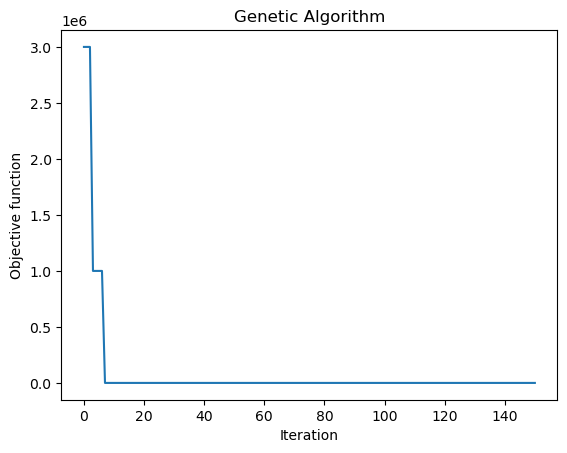

GA       → budget 1500.0, avg 28.17, hotspot 30.43, trees 18, time 121.972s
ACO      → budget 1500.0, avg 28.65, hotspot 32.11, trees 17, time 13.819s
ACO+Cand → budget 1490.0, avg 28.18, hotspot 31.49, trees 20, time 14.618s

--- Run 17 ---
Random   → budget 1475.0, avg 28.60, hotspot 31.68, trees 16, time 0.000s
 The best solution found:                                                                           
 [ 1.  0.  1.  0. 19.  0.  0.  0. 15.  9.  3.  0. 19.  6.  3.  0.  7. 24.
  1.  0. 23. 19.  2.  0. 13. 25.  2.  0. 19.  9.  0.  1. 21.  6.  1.  0.
  4.  0.  1.  0. 15.  2.  3.  0. 17.  2.  0.  0. 11.  1.  0.  0.  7. 10.
  0.  1. 13. 15.  0.  1. 22. 20.  0.  1. 16. 16.  2.  1.  1.  4.  3.  0.
 17. 21.  2.  0.  5.  3.  2.  0. 16. 13.  0.  1. 22. 18.  2.  1. 13. 15.
  1.  0.  4. 11.  2.  0.  8. 12.  3.  1. 24. 22.  1.  0.  9. 18.  1.  0.
 12. 23.  2.  0. 21. 27.  2.  0. 15.  7.  2.  1.  3.  1.  2.  0. 18. 16.
  0.  1.  9.  3.  3.  1.  8. 15.  1.  0.  4. 11.  2.  0. 17. 17.  2.  0

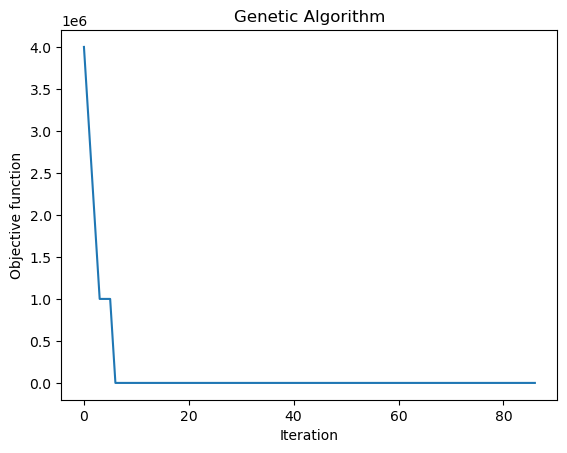


ACO      → budget 1465.0, avg 28.36, hotspot 31.88, trees 18, time 14.145s
ACO+Cand → budget 1470.0, avg 28.41, hotspot 31.17, trees 17, time 13.754s

--- Run 18 ---
Random   → budget 1490.0, avg 28.61, hotspot 31.92, trees 14, time 0.000s
 The best solution found:                                                                           
 [ 8. 15.  3.  0.  6. 20.  0.  0. 10.  7.  1.  0. 27. 14.  2.  0. 15. 21.
  1.  0.  8. 16.  1.  0. 14. 16.  0.  1. 10. 16.  3.  1. 12. 16.  0.  1.
 20.  6.  0.  1. 10. 26.  1.  0.  8.  9.  2.  0. 17. 26.  0.  1. 22.  3.
  3.  0. 15. 14.  3.  1. 28.  2.  0.  1. 24. 18.  3.  1.  8. 19.  0.  1.
 20. 18.  2.  0. 13. 24.  1.  0.  6. 27.  1.  0. 17. 11.  0.  1. 24. 24.
  3.  0. 19. 21.  2.  1. 21.  2.  0.  0. 13. 16.  1.  0. 16. 23.  0.  1.
  7.  7.  0.  0.  4. 14.  1.  1. 11. 28.  1.  0. 21. 21.  0.  0. 17. 26.
  3.  0.  4.  3.  0.  0. 15. 12.  1.  0.  9. 19.  0.  1.  9. 14.  0.  0.
  0.  2.  1.  0. 21. 17.  0.  1. 20. 25.  3.  0. 18. 10.  0.  1.  0. 18.


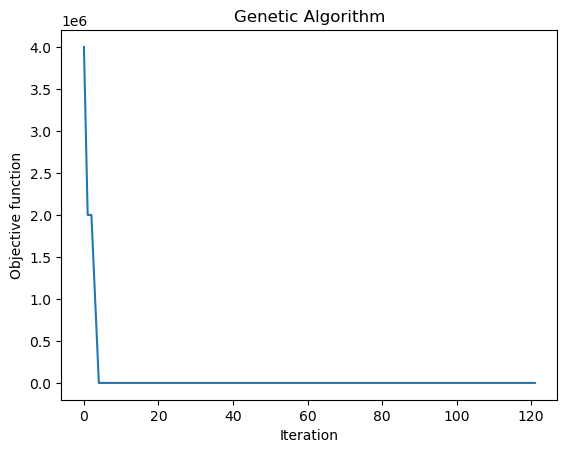


ACO      → budget 1465.0, avg 28.56, hotspot 32.06, trees 18, time 13.859s
ACO+Cand → budget 1500.0, avg 28.32, hotspot 31.67, trees 19, time 14.209s

--- Run 19 ---
Random   → budget 1460.0, avg 28.45, hotspot 31.17, trees 13, time 0.000s
 The best solution found:                                                                           
 [20.  3.  0.  0. 14.  5.  0.  1. 20.  0.  1.  0.  9.  1.  1.  0. 24. 23.
  2.  0. 16.  0.  1.  0.  7. 17.  1.  0. 19.  9.  1.  0. 21. 19.  0.  1.
 17. 21.  3.  1. 16. 22.  3.  1. 28.  2.  2.  0.  2.  9.  1.  0.  1. 21.
  1.  0. 10.  4.  3.  0. 20.  8.  2.  1. 10. 14.  3.  1. 19. 13.  1.  0.
 23.  0.  2.  0. 16.  6.  2.  0. 16. 25.  2.  0. 27.  4.  1.  1. 14.  5.
  2.  0. 14. 24.  2.  0. 25.  9.  0.  1. 18. 14.  1.  0. 20. 19.  1.  1.
  6. 10.  1.  0.  6. 26.  3.  0. 25. 17.  0.  0. 24. 22.  3.  0. 16. 21.
  0.  0. 10.  6.  0.  0. 12. 22.  0.  0. 13. 20.  3.  1.  0. 24.  3.  0.
 18. 24.  2.  0. 21.  4.  0.  1. 20. 28.  0.  0. 27.  5.  2.  0.  2. 21.


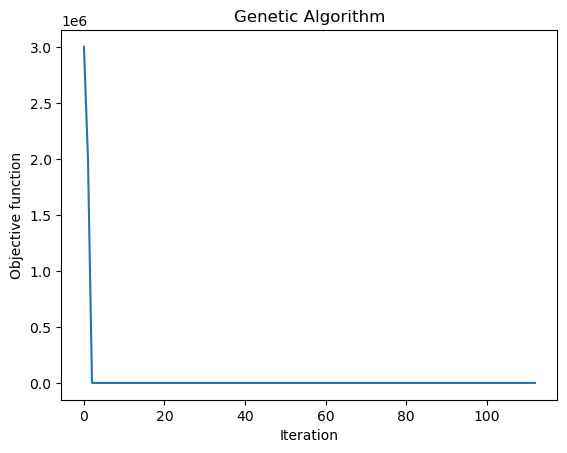


ACO      → budget 1475.0, avg 28.73, hotspot 31.96, trees 17, time 13.326s
ACO+Cand → budget 1500.0, avg 28.46, hotspot 31.35, trees 19, time 14.294s

--- Run 20 ---
Random   → budget 1470.0, avg 28.65, hotspot 31.69, trees 14, time 0.000s
 The best solution found:                                                                           
 [13. 23.  1.  0. 19. 13.  1.  1. 23. 12.  3.  0. 13.  6.  0.  0.  4. 16.
  2.  0. 17. 13.  1.  1. 27.  6.  2.  1. 12.  6.  0.  0.  5. 26.  2.  0.
 28.  7.  0.  0.  1. 17.  3.  0. 23.  9.  1.  0. 25. 27.  0.  0. 13. 19.
  3.  1. 17.  9.  3.  1. 22. 21.  1.  0. 12. 18.  1.  0. 15. 16.  3.  1.
 10.  2.  1.  0. 15. 19.  0.  1. 17. 19.  2.  0. 13.  2.  3.  0.  1. 23.
  2.  0. 17. 20.  0.  1. 13.  0.  2.  0.  5.  8.  3.  0. 19. 12.  1.  0.
 18. 17.  2.  0. 16.  9.  2.  0.  6. 19.  3.  0. 23. 28.  1.  0. 18.  8.
  0.  1. 17. 22.  0.  1. 26.  0.  0.  0. 13. 15.  3.  1. 15. 28.  0.  1.
 24. 22.  3.  0.  7.  9.  3.  0. 16. 12.  0.  1. 24. 24.  3.  1. 24. 16.


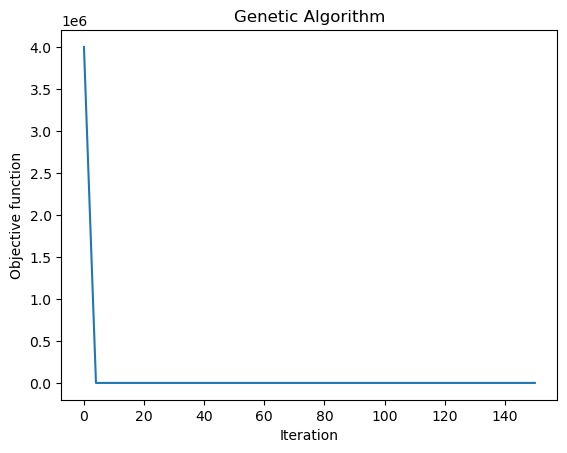

GA       → budget 1500.0, avg 28.16, hotspot 30.29, trees 16, time 121.127s
ACO      → budget 1470.0, avg 28.39, hotspot 31.83, trees 17, time 13.297s
ACO+Cand → budget 1495.0, avg 28.31, hotspot 31.80, trees 18, time 13.694s

--- Run 21 ---
Random   → budget 1485.0, avg 28.54, hotspot 31.56, trees 15, time 0.000s
 The best solution found:                                                                           
 [16. 16.  3.  0.  5. 24.  0.  0. 15. 14.  0.  1.  6.  2.  1.  0.  0. 27.
  0.  0. 19. 18.  0.  0. 11.  2.  2.  0. 11.  8.  2.  0. 24.  5.  0.  0.
  7.  4.  0.  0. 12. 18.  3.  1. 26. 16.  0.  0. 12. 24.  0.  0. 22. 21.
  2.  0.  5. 25.  2.  0. 15.  2.  0.  1. 10. 19.  0.  1. 15.  3.  0.  0.
 13. 28.  3.  0. 17. 20.  3.  0. 12. 19.  0.  1. 12.  0.  0.  0. 28. 22.
  1.  0.  3. 15.  3.  0. 12. 21.  1.  0. 16. 16.  3.  1. 15. 16.  3.  1.
 26.  3.  2.  0.  0.  1.  2.  1. 10. 19.  1.  0. 20. 19.  1.  0. 17.  7.
  3.  1.  9. 16.  2.  0. 10.  4.  3.  0. 25.  7.  1.  1.  4.  6.  0.  0

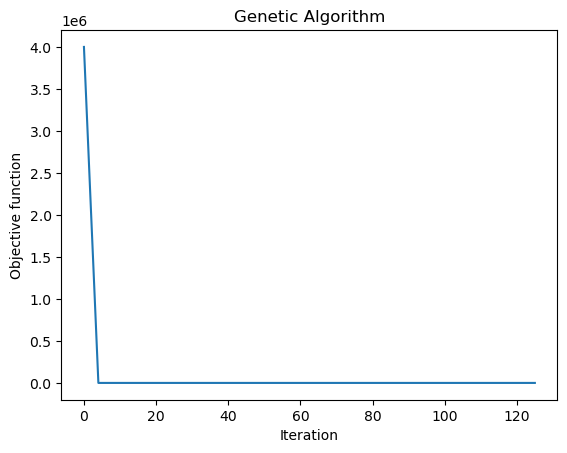


ACO      → budget 1485.0, avg 28.42, hotspot 31.67, trees 18, time 13.880s
ACO+Cand → budget 1500.0, avg 28.54, hotspot 31.79, trees 17, time 13.867s

--- Run 22 ---
Random   → budget 1480.0, avg 28.70, hotspot 31.83, trees 14, time 0.000s
 The best solution found:                                                                           
 [ 5.  3.  2.  0. 26. 24.  3.  0. 14. 26.  2.  0. 14.  8.  2.  0. 16.  7.
  3.  0.  7. 14.  0.  1.  8. 21.  3.  0. 16. 22.  2.  1. 23. 19.  2.  0.
 17. 21.  1.  1. 19. 15.  2.  0.  2.  2.  1.  0.  6.  0.  0.  0. 22. 13.
  2.  0. 13.  5.  0.  0. 12. 15.  0.  1.  6. 17.  1.  0.  6.  0.  3.  1.
 28. 15.  2.  0. 19. 20.  0.  1. 19. 10.  0.  1.  8. 16.  0.  0. 19. 27.
  3.  0. 13.  3.  2.  0. 18. 16.  0.  0.  6. 23.  3.  0.  2.  7.  1.  0.
 21. 17.  2.  0.  3. 19.  2.  0.  0. 26.  2.  0. 21. 23.  0.  1.  1.  2.
  0.  0.  2.  0.  0.  0. 13. 13.  2.  0. 15. 13.  3.  0. 25. 12.  1.  0.
 27. 23.  2.  0. 18. 17.  0.  1. 27. 16.  3.  0. 17. 12.  0.  1. 23.  5.


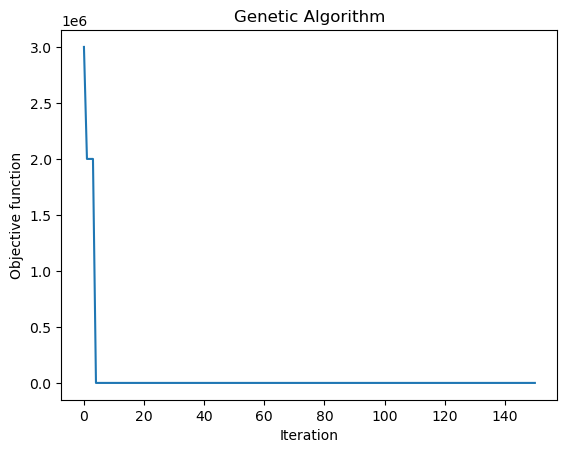

GA       → budget 1465.0, avg 28.11, hotspot 30.17, trees 16, time 121.333s
ACO      → budget 1485.0, avg 28.30, hotspot 31.38, trees 17, time 13.430s
ACO+Cand → budget 1470.0, avg 28.50, hotspot 31.59, trees 18, time 13.846s

--- Run 23 ---
Random   → budget 1495.0, avg 28.55, hotspot 31.68, trees 15, time 0.000s
 The best solution found:                                                                           
 [16. 23.  0.  1. 24. 27.  0.  0. 26. 13.  1.  0. 26. 13.  2.  0.  7.  4.
  1.  0. 14.  5.  2.  0. 24. 23.  0.  1. 15. 18.  2.  0. 10.  3.  1.  0.
 14. 24.  1.  0. 21. 25.  3.  0. 14.  5.  0.  0. 12.  5.  0.  0. 18. 24.
  2.  0. 21. 19.  0.  1.  1. 11.  3.  1.  7. 15.  2.  0. 15. 13.  1.  0.
 19. 19.  0.  1. 14. 24.  0.  1. 15. 19.  3.  1. 18. 24.  2.  0. 12.  0.
  1.  0.  9. 18.  0.  1.  2. 22.  0.  0. 14. 18.  2.  0.  9. 25.  3.  0.
 11. 14.  1.  0.  4. 13.  1.  0. 24. 22.  1.  0.  3. 20.  3.  1. 18. 18.
  3.  1.  6. 23.  1.  0.  2. 16.  2.  0. 28. 17.  2.  0. 14. 18.  2.  0

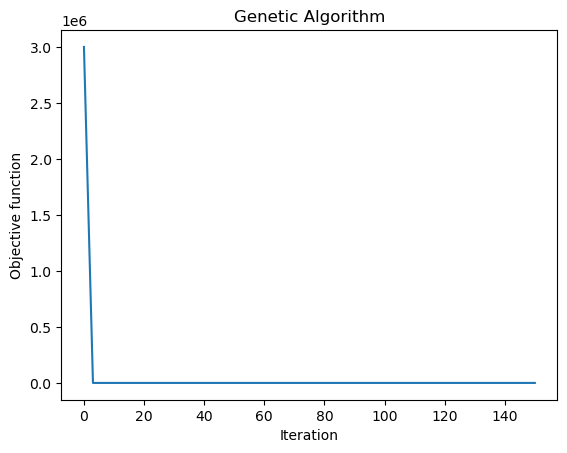

GA       → budget 1500.0, avg 28.08, hotspot 30.30, trees 16, time 123.661s
ACO      → budget 1500.0, avg 28.46, hotspot 31.81, trees 17, time 13.733s
ACO+Cand → budget 1485.0, avg 28.24, hotspot 31.61, trees 18, time 14.044s

--- Run 24 ---
Random   → budget 1485.0, avg 28.52, hotspot 31.59, trees 14, time 0.000s
 The best solution found:                                                                           
 [21. 18.  2.  0. 14. 27.  3.  1. 24. 18.  3.  1.  9.  8.  3.  0. 17. 13.
  0.  1. 28. 22.  1.  0. 18. 11.  1.  0.  5.  9.  2.  0. 24. 25.  0.  1.
 17.  7.  1.  0. 25.  0.  1.  0. 15.  5.  0.  1.  6.  5.  0.  1. 27. 26.
  0.  0.  5. 21.  0.  0.  3. 13.  3.  0. 26.  3.  2.  0. 21.  3.  0.  0.
 24. 27.  0.  0. 15. 11.  2.  0.  1. 10.  2.  0. 13.  6.  2.  0.  5. 10.
  0.  1. 21. 17.  3.  1. 23.  7.  3.  0.  6.  8.  3.  1.  7. 24.  1.  1.
 15. 12.  3.  0.  8. 20.  0.  1. 21. 12.  3.  0. 12.  8.  0.  0. 11. 10.
  1.  0.  2. 20.  3.  0. 10. 25.  0.  0.  9. 21.  1.  0. 11. 15.  3.  1

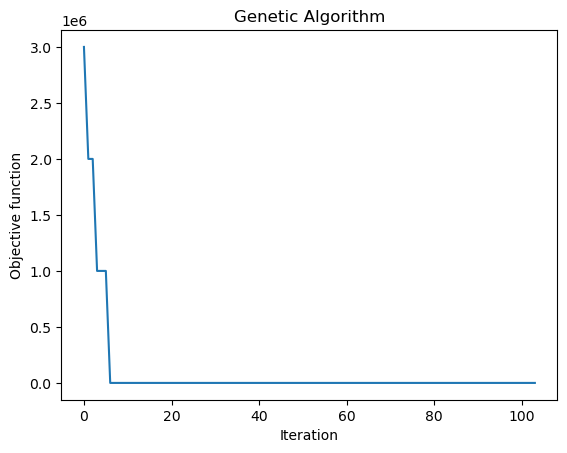


ACO      → budget 1470.0, avg 28.26, hotspot 31.40, trees 19, time 14.214s
ACO+Cand → budget 1500.0, avg 28.59, hotspot 32.10, trees 18, time 14.091s

--- Run 25 ---
Random   → budget 1500.0, avg 28.39, hotspot 31.58, trees 15, time 0.000s
 The best solution found:                                                                           
 [21.  4.  2.  0. 15. 11.  0.  1.  3. 25.  3.  0. 24. 25.  2.  0. 24. 18.
  0.  1. 20. 24.  3.  0. 19.  1.  2.  0. 19. 16.  0.  1.  5. 24.  1.  0.
 19. 21.  0.  1. 25.  0.  0.  0. 16.  9.  0.  1.  8. 22.  3.  0. 13.  2.
  2.  0.  3. 11.  2.  0. 23. 11.  0.  0. 13. 17.  3.  1.  4. 26.  3.  0.
  3. 18.  3.  0. 19. 27.  3.  0. 11.  7.  3.  0. 11. 23.  0.  0. 26.  0.
  3.  0. 14.  7.  3.  1. 13. 21.  0.  0. 13. 15.  0.  0. 19. 20.  0.  1.
 25. 20.  0.  1.  6. 10.  0.  0. 11. 26.  1.  0.  9. 16.  2.  0.  6.  3.
  1.  0. 28. 15.  0.  0.  6. 20.  1.  0. 12. 12.  3.  1. 10. 21.  3.  1.
 22. 18.  3.  0.  1. 19.  1.  0. 24.  2.  0.  1. 10. 22.  0.  1.  8.  4.


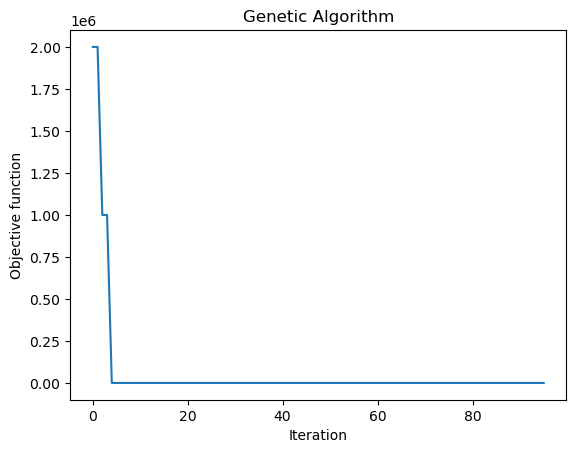


ACO      → budget 1495.0, avg 28.19, hotspot 31.72, trees 18, time 13.712s
ACO+Cand → budget 1485.0, avg 28.43, hotspot 31.43, trees 18, time 13.823s

✅ Evaluation completed.

=== Raw results per run ===
| Algorithm        |   Run |   Budget Remaining |   Δ Avg Temp |   Δ Hot Temp |   Num Trees |     Exec Time |
|:-----------------|------:|-------------------:|-------------:|-------------:|------------:|--------------:|
| Random Insertion |     1 |                 25 |      1.33695 |     0.996866 |          16 |   9.7482e-05  |
| Random Insertion |     2 |                 30 |      1.16175 |     1.26204  |          15 |   0.000102989 |
| Random Insertion |     3 |                 15 |      1.18871 |     0.989382 |          15 |   9.7615e-05  |
| Random Insertion |     4 |                  5 |      1.01566 |     0.962474 |          13 |   9.9338e-05  |
| Random Insertion |     5 |                 20 |      1.04262 |     0.704367 |          14 |   7.5114e-05  |
| Random Insertion |     

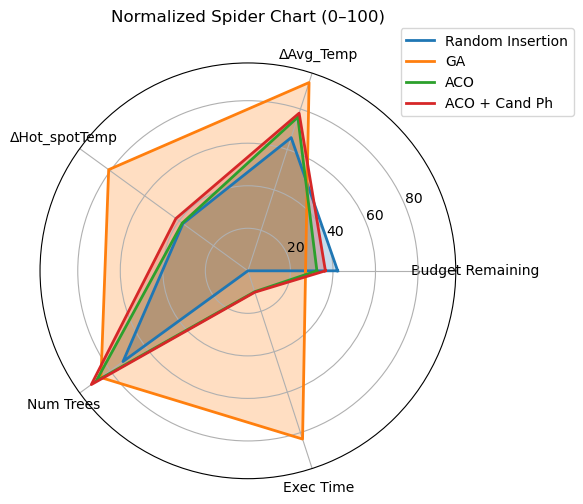

In [21]:
if __name__ == "__main__":
    # === 1. Parametri e multi-run ===
    runs = 25
    stats, algorithms = evaluate_multiple_runs(
        runs, type_matrix, temp_matrix, budget_max, type_to_num, tree_species
    )

    # === 2. Tabella dei valori originali (“raw”) ===
    import pandas as pd

    # Otteniamo base_avg e base_hot per calcolare i delta
    base_avg, base_hot = calculate_objective_stats(temp_matrix, temp_matrix)

    rows = []
    for i, alg in enumerate(algorithms):
        for run_idx, entry in enumerate(stats[i]):
            used_budget, avg_temp, hot_temp, n_trees, exec_time = entry
            budget_rem   = budget_max - used_budget
            delta_avg    = base_avg - avg_temp
            delta_hot    = base_hot - hot_temp
            rows.append([
                alg,
                run_idx + 1,
                budget_rem,
                delta_avg,
                delta_hot,
                n_trees,
                exec_time
            ])

    df_raw = pd.DataFrame(
        rows,
        columns=[
            'Algorithm', 'Run',
            'Budget Remaining',
            'Δ Avg Temp',
            'Δ Hot Temp',
            'Num Trees',
            'Exec Time'
        ]
    )

    # Stampo la tabella raw
    print("\n=== Raw results per run ===")
    print(df_raw.to_markdown(index=False))

    # === 2. Normalizzazione e Spider Chart ===
    # Trasforma in array [alg, run, metric]
    raw = np.zeros((len(algorithms), runs, 5))
    for i, alg in enumerate(algorithms):
        for j, entry in enumerate(stats[i]):
            raw[i, j] = entry  # (budget, avg, avg_hot, n_trees, time)

    # Metriche: budget usato → vogliamo budget residuo, e delta vs base
    base_avg, base_hot = calculate_objective_stats(temp_matrix, temp_matrix)
    # Converte budget usato in residuo e avg/hot in delta miglioramento
    # Sostituisci raw[:, :, 0] con budget_max - raw[:,:,0], e raw[:,:,1] con base_avg-raw[:,:,1], ecc.
    raw[:, :, 0] = budget_max - raw[:, :, 0]
    raw[:, :, 1] = base_avg - raw[:, :, 1]
    raw[:, :, 2] = base_hot - raw[:, :, 2]

    # Trova i massimi e le medie
    max_vals = raw.max(axis=(0,1))
    mean_vals = raw.mean(axis=1)
    norm = mean_vals / max_vals * 100

    df_norm = pd.DataFrame(
        norm,
        index=algorithms,
        columns=['Budget Remaining', 'ΔAvg_Temp', 'ΔHot_spotTemp', 'Num Trees', 'Exec Time']
    )

    # Spider chart
    categories = df_norm.columns.tolist()
    N = len(categories)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist() + [0]

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    for alg in algorithms:
        vals = df_norm.loc[alg].tolist()
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, label=alg)
        ax.fill(angles, vals, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_title("Normalized Spider Chart (0–100)", y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))
    plt.tight_layout()
    plt.show()



=== Summary Table ===
          Algorithm  Mean Budget  Std Budget  Mean Avg Temp  Std Avg Temp  \
0  Random Insertion       1481.0       12.57          28.62          0.10   
1                GA       1487.8       12.17          28.11          0.09   
2               ACO       1485.4       14.14          28.43          0.13   
3     ACO + Cand Ph       1483.6       12.21          28.39          0.10   

   Mean Hotspot Temp  Std Hotspot Temp  
0              31.78              0.21  
1              30.43              0.27  
2              31.77              0.21  
3              31.65              0.24  


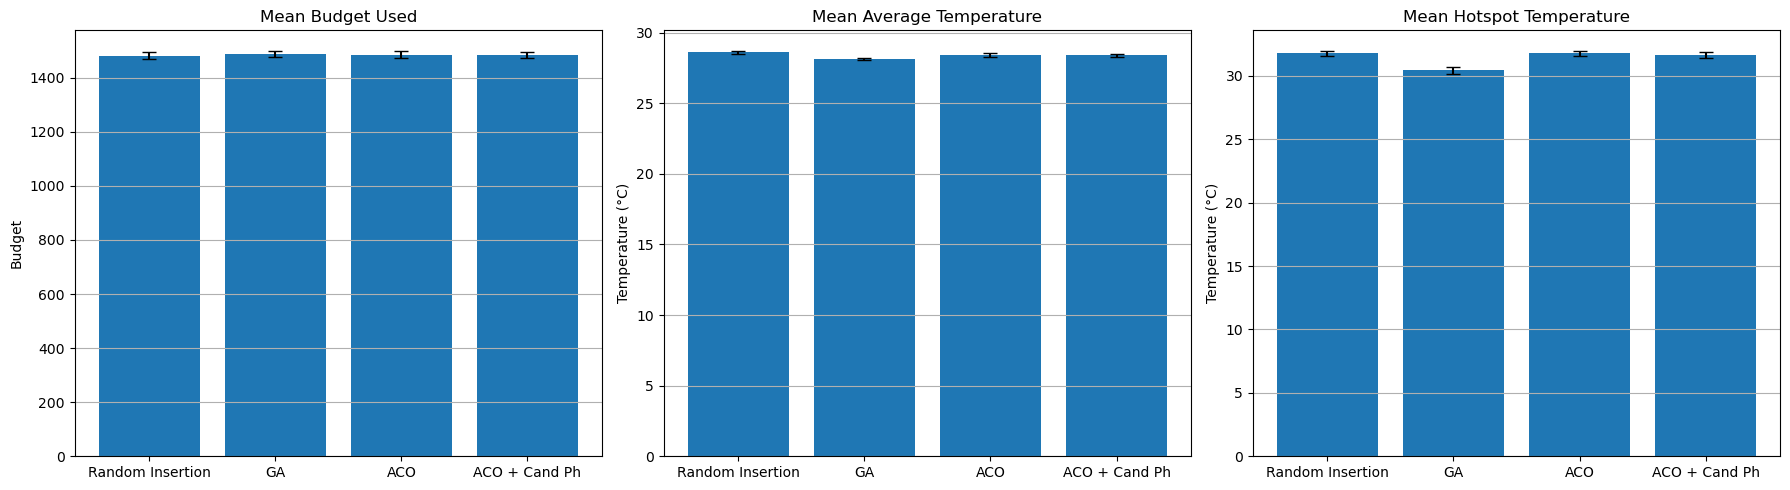

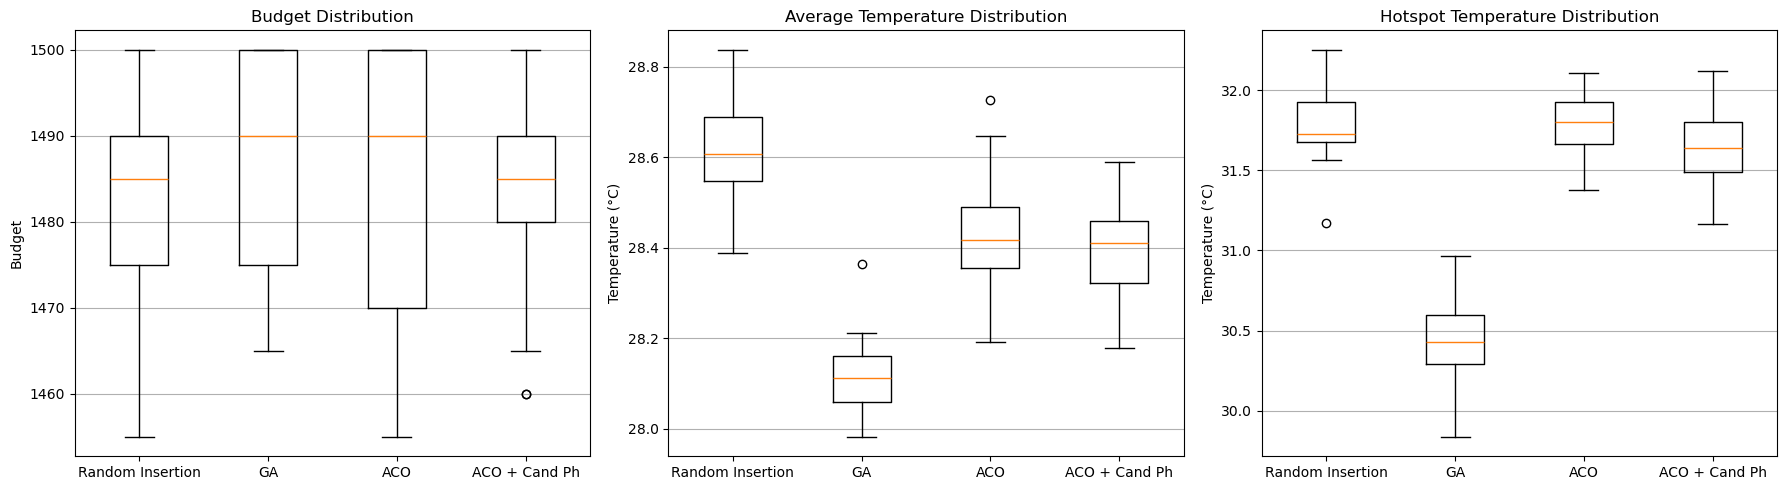

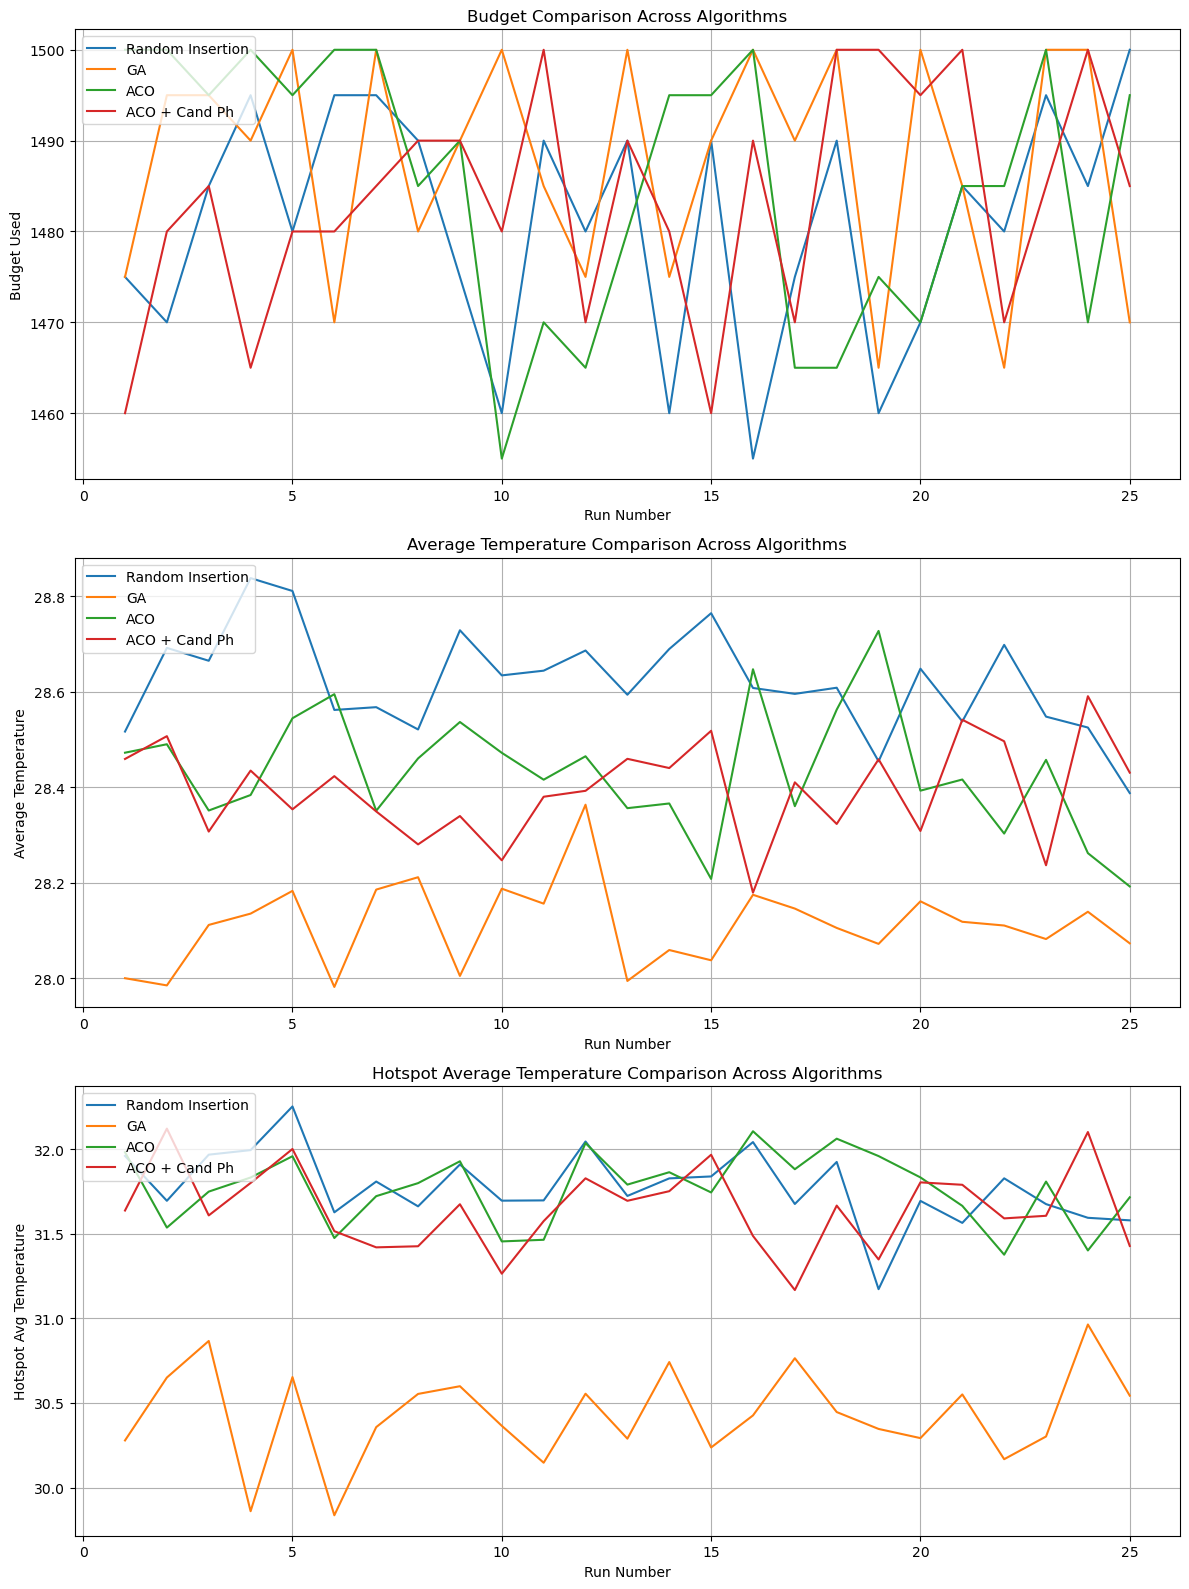

In [22]:
algorithms = ['Random Insertion', 'GA', 'ACO', 'ACO + Cand Ph'] 
summary_df = summarize_algorithm_runs(stats, algorithms)

In [23]:
summary_df

Algorithm  Mean Budget  Std Budget  Mean Avg Temp  Std Avg Temp  \
0  Random Insertion       1481.0   12.569805      28.620728      0.104146   
1                GA       1487.8   12.172099      28.111008      0.085627   
2               ACO       1485.4   14.136478      28.431296      0.125790   
3     ACO + Cand Ph       1483.6   12.208194      28.394460      0.099983   

   Mean Hotspot Temp  Std Hotspot Temp  
0          31.778313          0.210096  
1          30.431720          0.270421  
2          31.765949          0.208219  
3          31.651075          0.240277